# Evaluating the dilution hypothesis

Negative selection against Neanderthal introgression is currently widely accepted as an explanation for this decline. However, after testing of previously proposed models of selection against introgression (mainly selection against Neanderthal variants that accumulated in the Neanderthal population due to their low $N_e$) we find that these models cannot produce the continuous decline in Neanderthal ancestry observed in the real data.

There are at least two possible alternative explanations. One is a more complex selection model, perhaps some form of negative epistasis (this is what we are currently investigating). The second model involves a dilution of Neanderthal ancestry during part of the last 55 thousand years.

Several earlier studies indicate that a simple dilution scenario is not entirely implausible:

1. European individuals seem to carry various proportions of ancestry from three ancestral populations, one of them being a mysterious "basal Eurasian" population. [@lazaridis_ancient_2014]
2. Ancient modern human samples from the Upper Palaeolithic Europe show (beginning around 14ky) affinity towards present-day Near East populations. [@fu_genetic_2016]
3. Ancient Near East individuals derive part of their ancestry from the basal Eurasian population, which appears to have had much lower amounts of Neanderthal ancestry than any ancient or present-day modern human. [@lazaridis_genomic_2016]. If the ancient Near Easterners experienced dilution of their Neanderthal ancestry and they also admixed with EMHs in Europe, it follows that Neanderthal ancestry in Europeans was diluted as well.

This notebook contains a very simple exploratory analysis to evaluate whether this dilution hypothesis is possible.

In [2]:
suppressPackageStartupMessages({

library(tidyverse)
library(admixr)

source("../code/utils.R")

})

In [3]:
load("../data/RData/admixtools_pop_relationships.ipynb")

In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [4]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT_PREFIX <- paste0(EIGENSTRAT_DIR, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "all.transitions.snp")

In [5]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

### Generate a table of SNPs to filter out (transitions)

In [5]:
read_snp(SNP_FILE) %>%
    keep_transitions %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

In [6]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# Testing the affinity towards present-day populations using D statistic

We used an approach similar to the method used in the Ice Age paper [Fu et al., 2016] (Supplementary note 11, page 59), but using the full set of EMH samples and also adding the present-day Europeans (which were missing in the Fu et al., 2016 paper). Specifically, we calculated the following D statistic for each ancient or present-day European X:



$D(\textrm{Kostenki14}, \textrm{X}; \textrm{present-day population}, \textrm{Mbuti})$,



which tests whether a given individual X shares more alleles with some of the present-day human populations than with an ancient hunter gatherer Kostenki 14.

<font color="red">
   
Plotting the change in Z score over time is weird - someone might argue that significance is a yes-or-no thing, not a gradient. How about I calculate "raw" f4 stat (which is a direct measure of the amount of sharing) and plot that?

</font>

In [41]:
set_dim <- function(w, h, r=300) {
    options(repr.plot.width=w, repr.plot.height=h, repr.plot.res=r)
}
    
plot_z <- function(df, z_cut=3, ylim=c(-23, 23), title=NULL) {
    print(ggplot(mutate(df, Y=paste("Y =", Y)), aes(age, Zscore)) +
        geom_point(aes(color=Y), size=3, alpha=1/2) +
        #facet_wrap(~Y, ncol=4) +
        geom_hline(yintercept=c(z_cut, -z_cut), linetype=2) +
        geom_hline(yintercept=0, linetype=2, color="red") +
        xlim(40000, 0) + coord_cartesian(y=ylim) +
#        ggtitle(paste0("D(", unique(df$W), ", test X; ", unique(df$Y), "; ", unique(df$Z), ")")) +
        ggtitle(title) + xlab("age [years before present]") +
        theme(legend.position="none"))
}

plot_d <- function(df, title) {
    print(ggplot(mutate(df, Y=paste("Y =", Y)), aes(age, D)) +
        geom_point(aes(color=abs(Zscore) > 3), size=3, alpha=1/2) +
        #geom_errorbar(aes(ymin=D - 3 * se, ymax=D + 3 * se)) +
        facet_wrap(~Y, ncol=4) +
        geom_hline(yintercept=0, linetype=3) +
        xlim(40000, 0) + ylim(-0.1, 0.05) +
        ggtitle(title) + xlab("age [years before present]") + #ggtitle(paste0("D(", unique(df$W), ", test X; SGDP pop Y; ", unique(df$Z), ")")) +
        theme(legend.position="bottom"))
}

Prepare the list of populations used in the rest of our analysis:

In [12]:
present_day_Y <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name,
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
#    "CentralAfrica"="Mbuti",
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite")
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_affinity_Mbuti"), present_day_Y)

ancient_X <- filter(samples, pop == "EMH", !name %in% c("UstIshim", "Kostenki14"))$name
modern_X <- filter(samples, pop == "WestEurasia", !name %in% present_day_Y[["NearEast"]])$name

Calculate the D statistics above for each present-day SGDP population:

## Mbuti outgroup - all SNPs

In [13]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_mbuti <- vector(mode = "list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="Kostenki14", X=ancient_X, Y=pop, Z="Mbuti",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="Kostenki14", X=modern_X, Y=pop, Z="Mbuti",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))
    
    affinity_dstats_mbuti[[pop]] <- bind_rows(ancient, modern)
}

In [28]:
df_affinity_mbuti <- bind_rows(affinity_dstats_mbuti) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(set="all", se=D / Zscore)

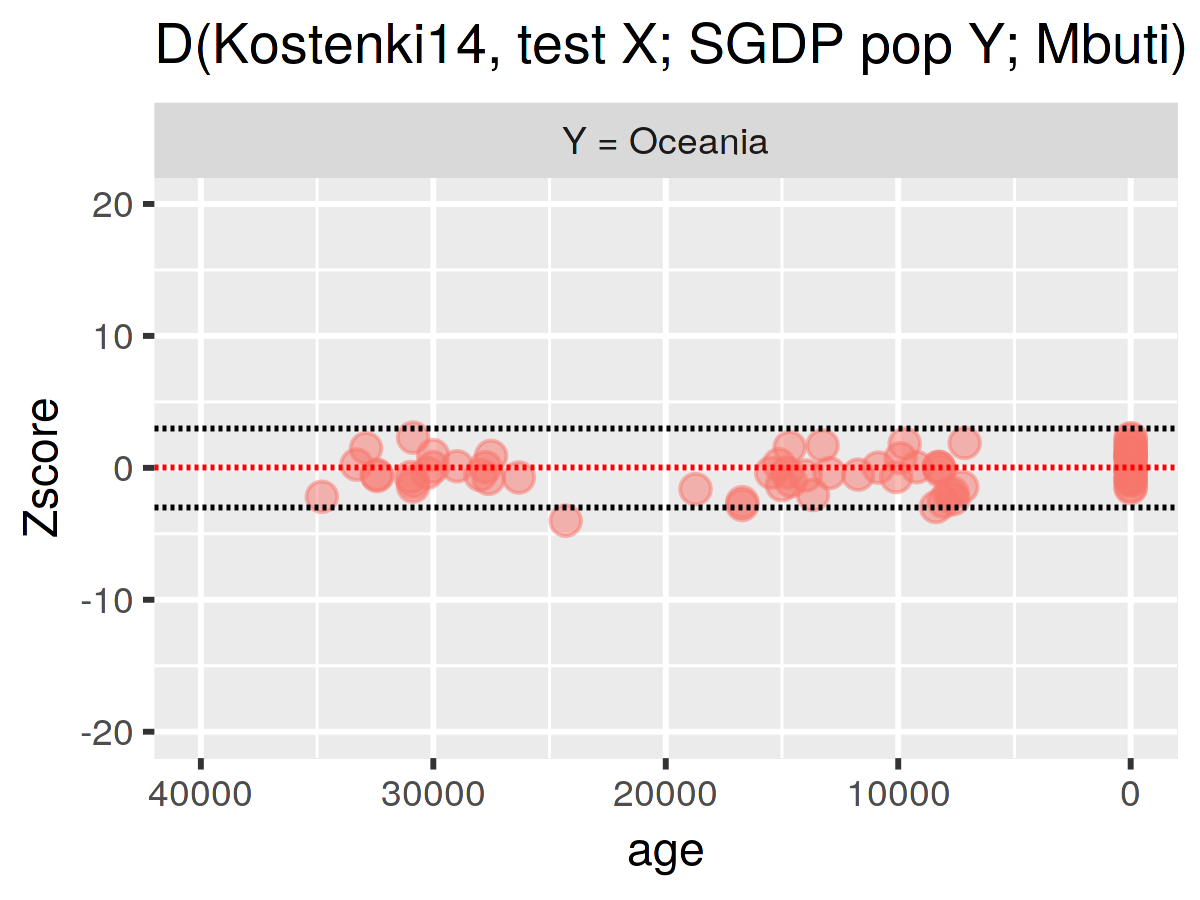

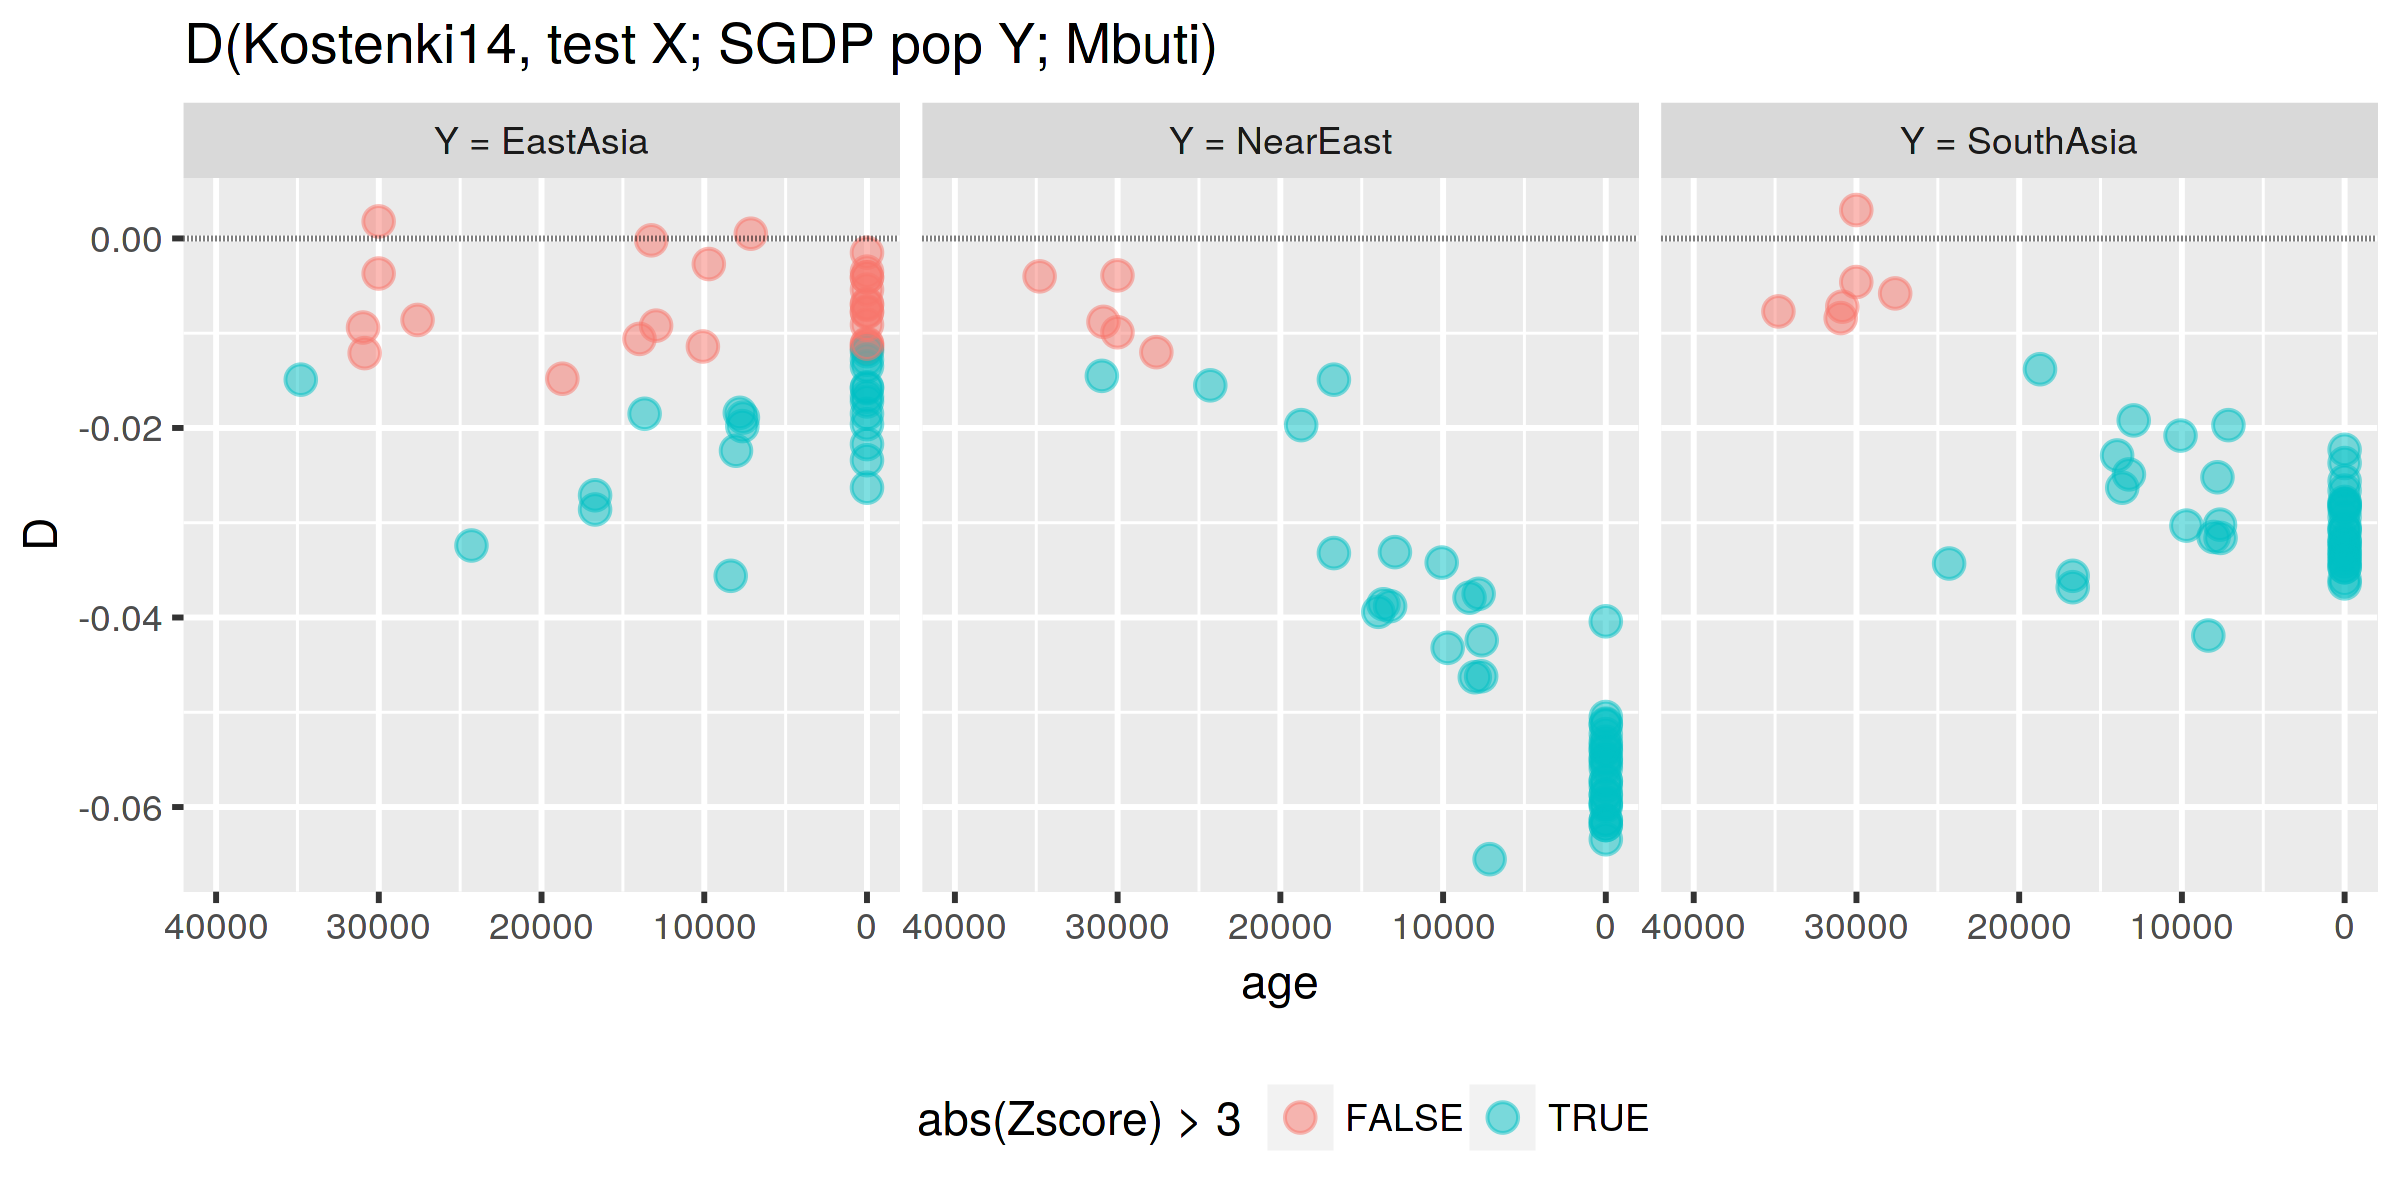

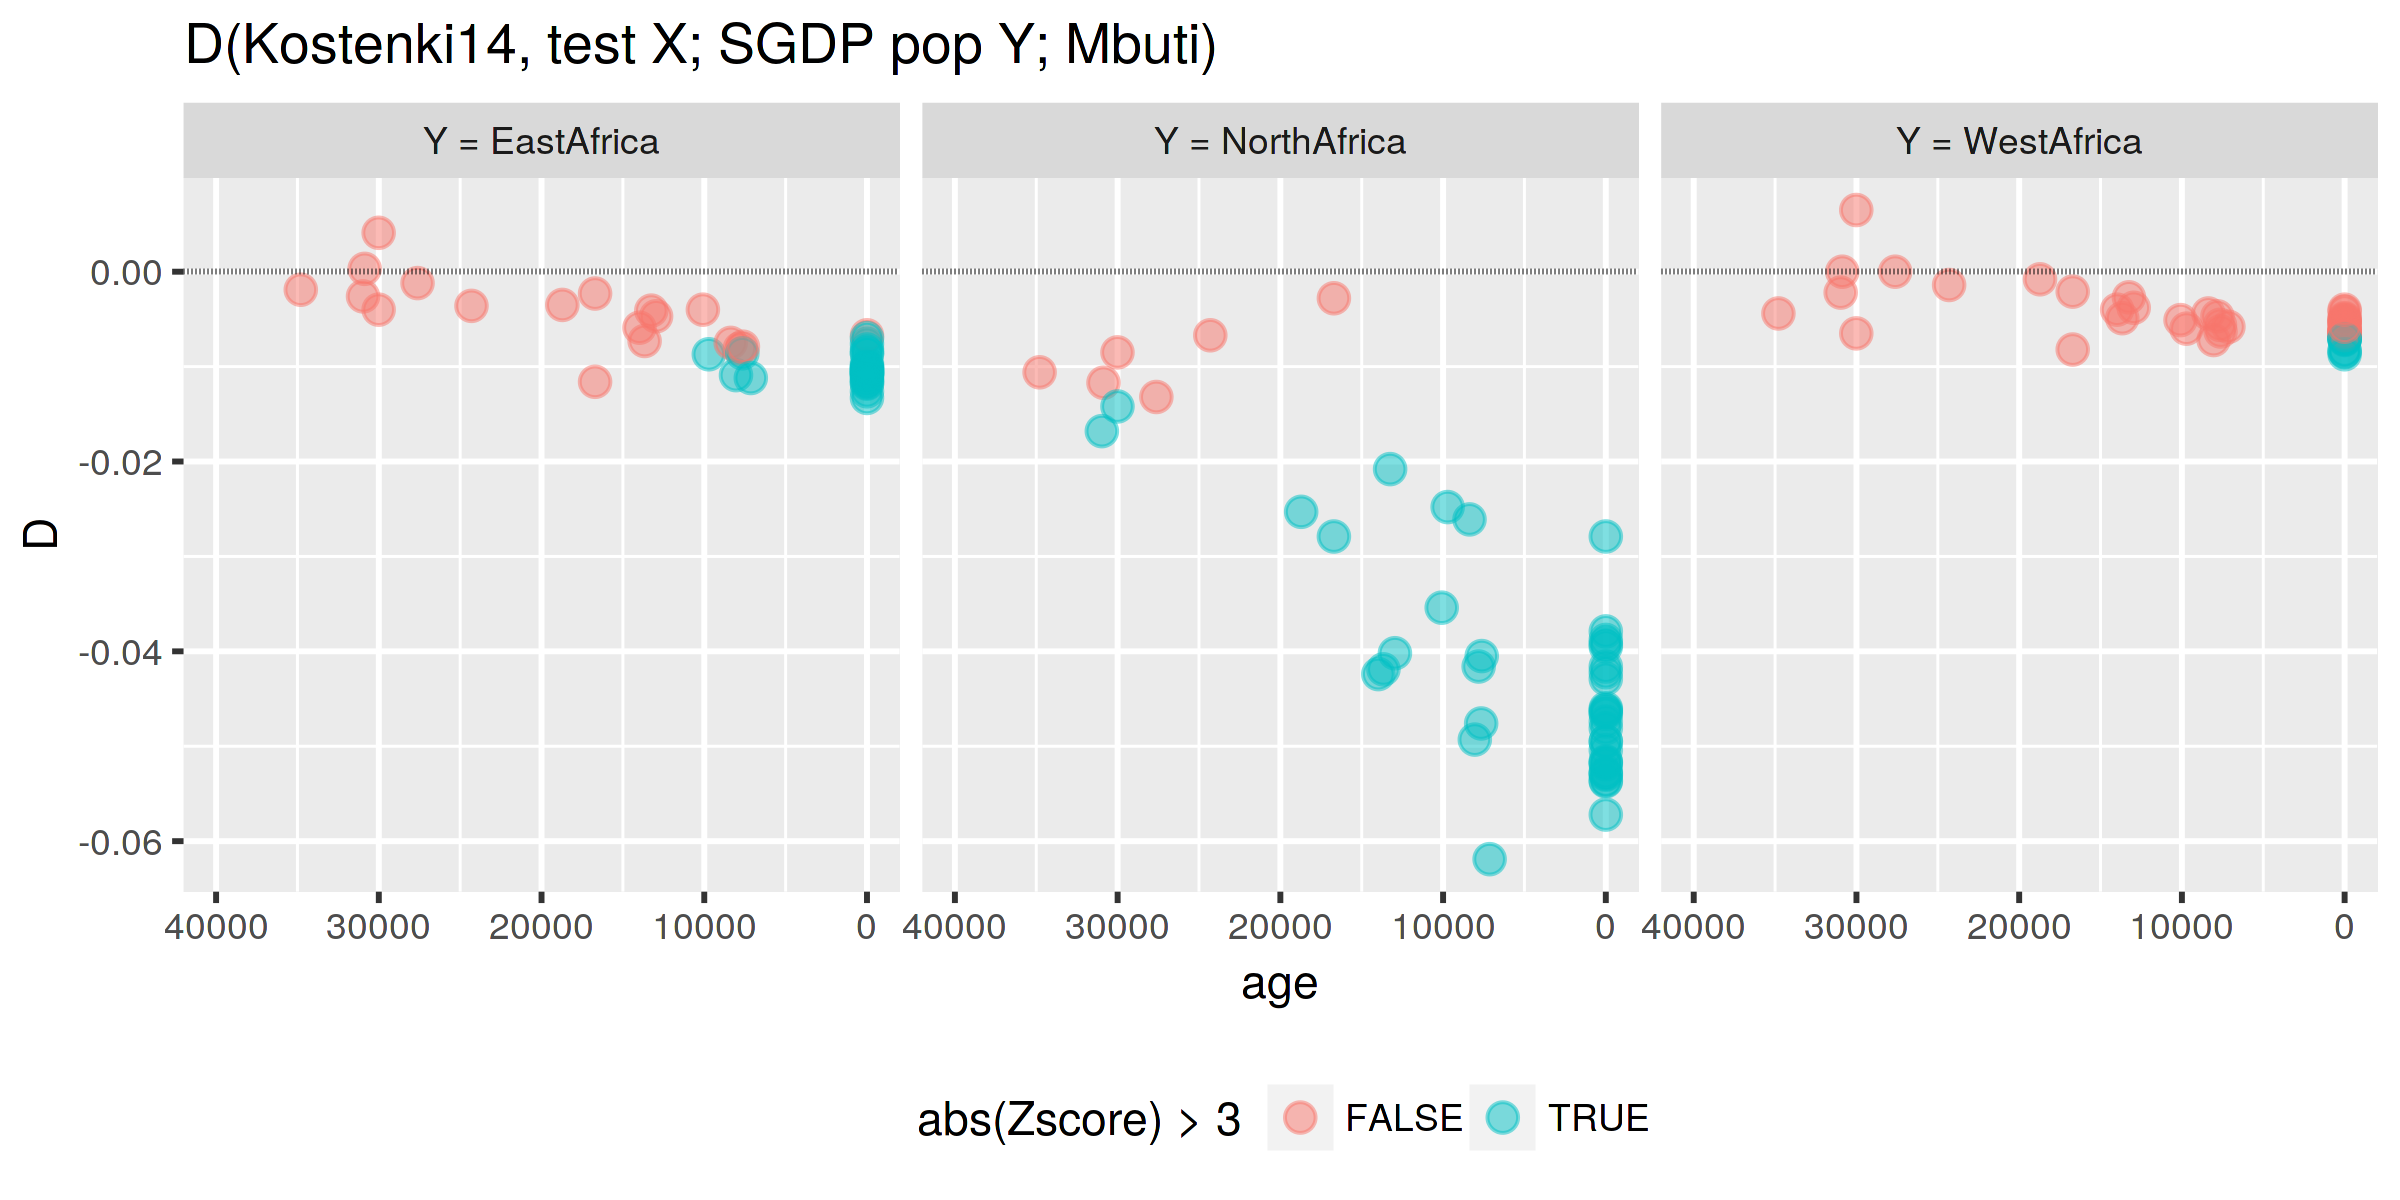

In [82]:
set_dim(4, 3, 300)
filter(df_affinity_mbuti, Y == "Oceania") %>% plot_z(ylim=c(-20, 20))

set_dim(8, 4, 300)
filter(df_affinity_mbuti, !str_detect(Y, "Africa"), !Y %in% c("Oceania", "America", "CentralAsiaSiberia")) %>%
filter(n_snps >= 100000) %>% plot_d

set_dim(8, 4, 300)
filter(df_affinity_mbuti, str_detect(Y, "Africa")) %>% 
filter(n_snps >= 100000) %>% plot_d

### Mbuti outgroup - TV only

In [181]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_mbuti_tv <- vector(mode = "list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="Kostenki14", X=ancient_X, Y=pop, Z="Mbuti",
                       badsnp=BADSNP_FILE, prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="Kostenki14", X=modern_X, Y=pop, Z="Mbuti",
                      badsnp=BADSNP_FILE, prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))
    
    affinity_dstats_mbuti_tv[[pop]] <- bind_rows(ancient, modern)
}

In [182]:
df_affinity_mbuti_tv <- bind_rows(affinity_dstats_mbuti_tv) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(set="transversions", se=D / Zscore)

<br><br><br><br><br>
From deleted comparison with Ko14 and Chimp - Interesting, with Chimp and an outgroup even Oceania shows a weak downward pattern. But this must be clearly an artifact of the data/statistic. No reason present-day Europeans to show evidence of admixture with Oceanians.

Could this be because of an excess damage in Kostenki 14? There is a long branch to chimp, and the other two populations are modern (at least the present-day ones are). Maybe Kostenki14 "shares" more alleles with Chimp because of false substitutions due to damage?

Let's test this on transversions only.

Alternatively, using UstIshim might work too (this sample should have only a limited amount of damage).

So, even TV only leads to a downward pattern of D statistics for Oceanians (which are supposed to be symmetrical).

It must be the "attraction" of Kostenki14 to Chimp, due to a longer branch.

$D(\textrm{Kostenki14}, \textrm{X}; \textrm{present-day population}, \textrm{Mbuti})$

$D = \frac{ABBA - BABA}{ABBA + BABA}$

Let's try with Ust-Ishim instead of Kostenki14 then.

## Ust-Ishim instead of Kostenki14 with Chimp as an outgroup

In [205]:
present_day_Y <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name,
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "CentralAfrica"="Mbuti",
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite")
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_affinity_Chimp"), present_day_Y)

ancient_X <- filter(samples, pop == "EMH", !name %in% c("UstIshim", "Kostenki14"))$name
modern_X <- filter(samples, pop == "WestEurasia", !name %in% present_day_Y[["NearEast"]])$name

In [206]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_chimp_ui <- vector(mode = "list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="UstIshim", X=ancient_X, Y=pop, Z="Chimp",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Chimp"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="UstIshim", X=modern_X, Y=pop, Z="Chimp",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Chimp"))
    
    affinity_dstats_chimp_ui[[pop]] <- bind_rows(ancient, modern)
}

In [207]:
# join Dstat results for ancient and present-day humans
df_affinity_chimp_ui <- bind_rows(affinity_dstats_chimp_ui) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(set="all", se=D / Zscore)

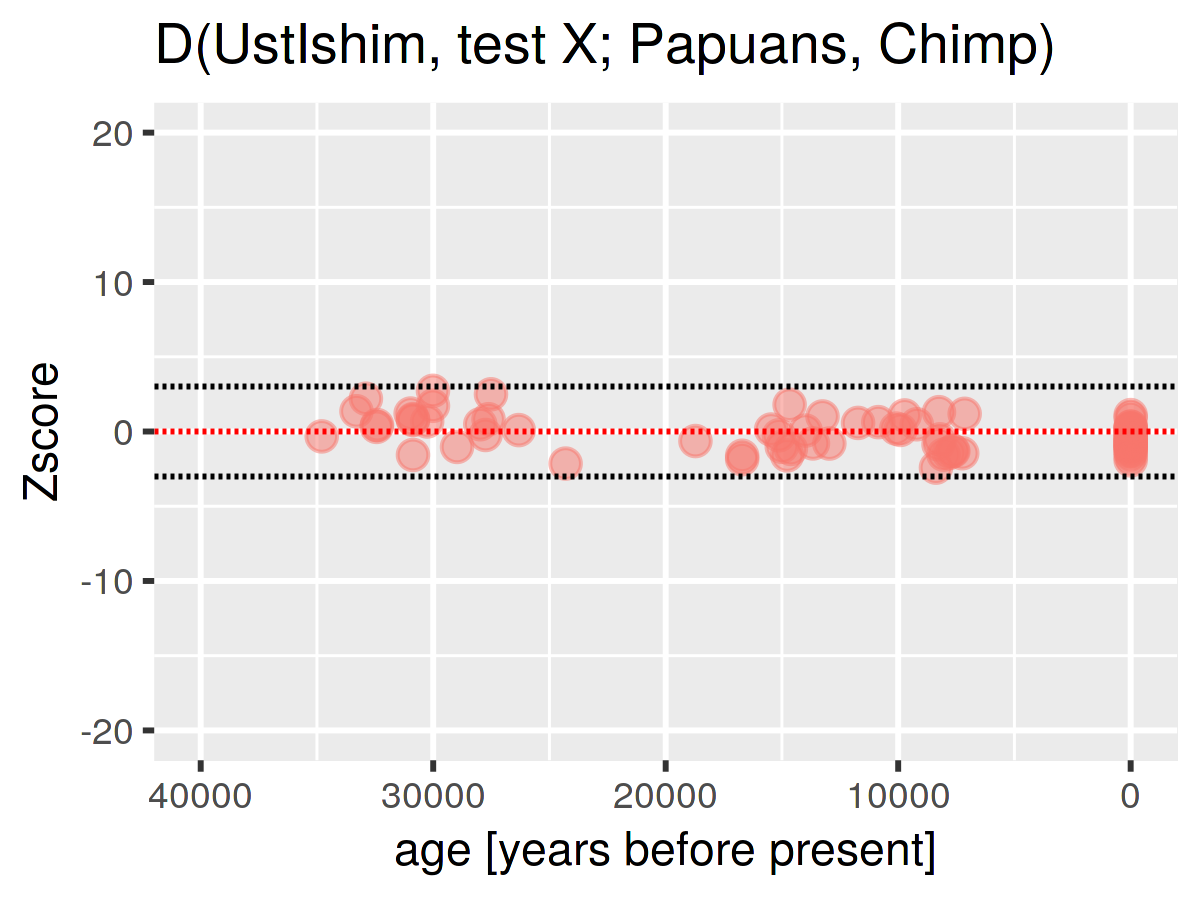

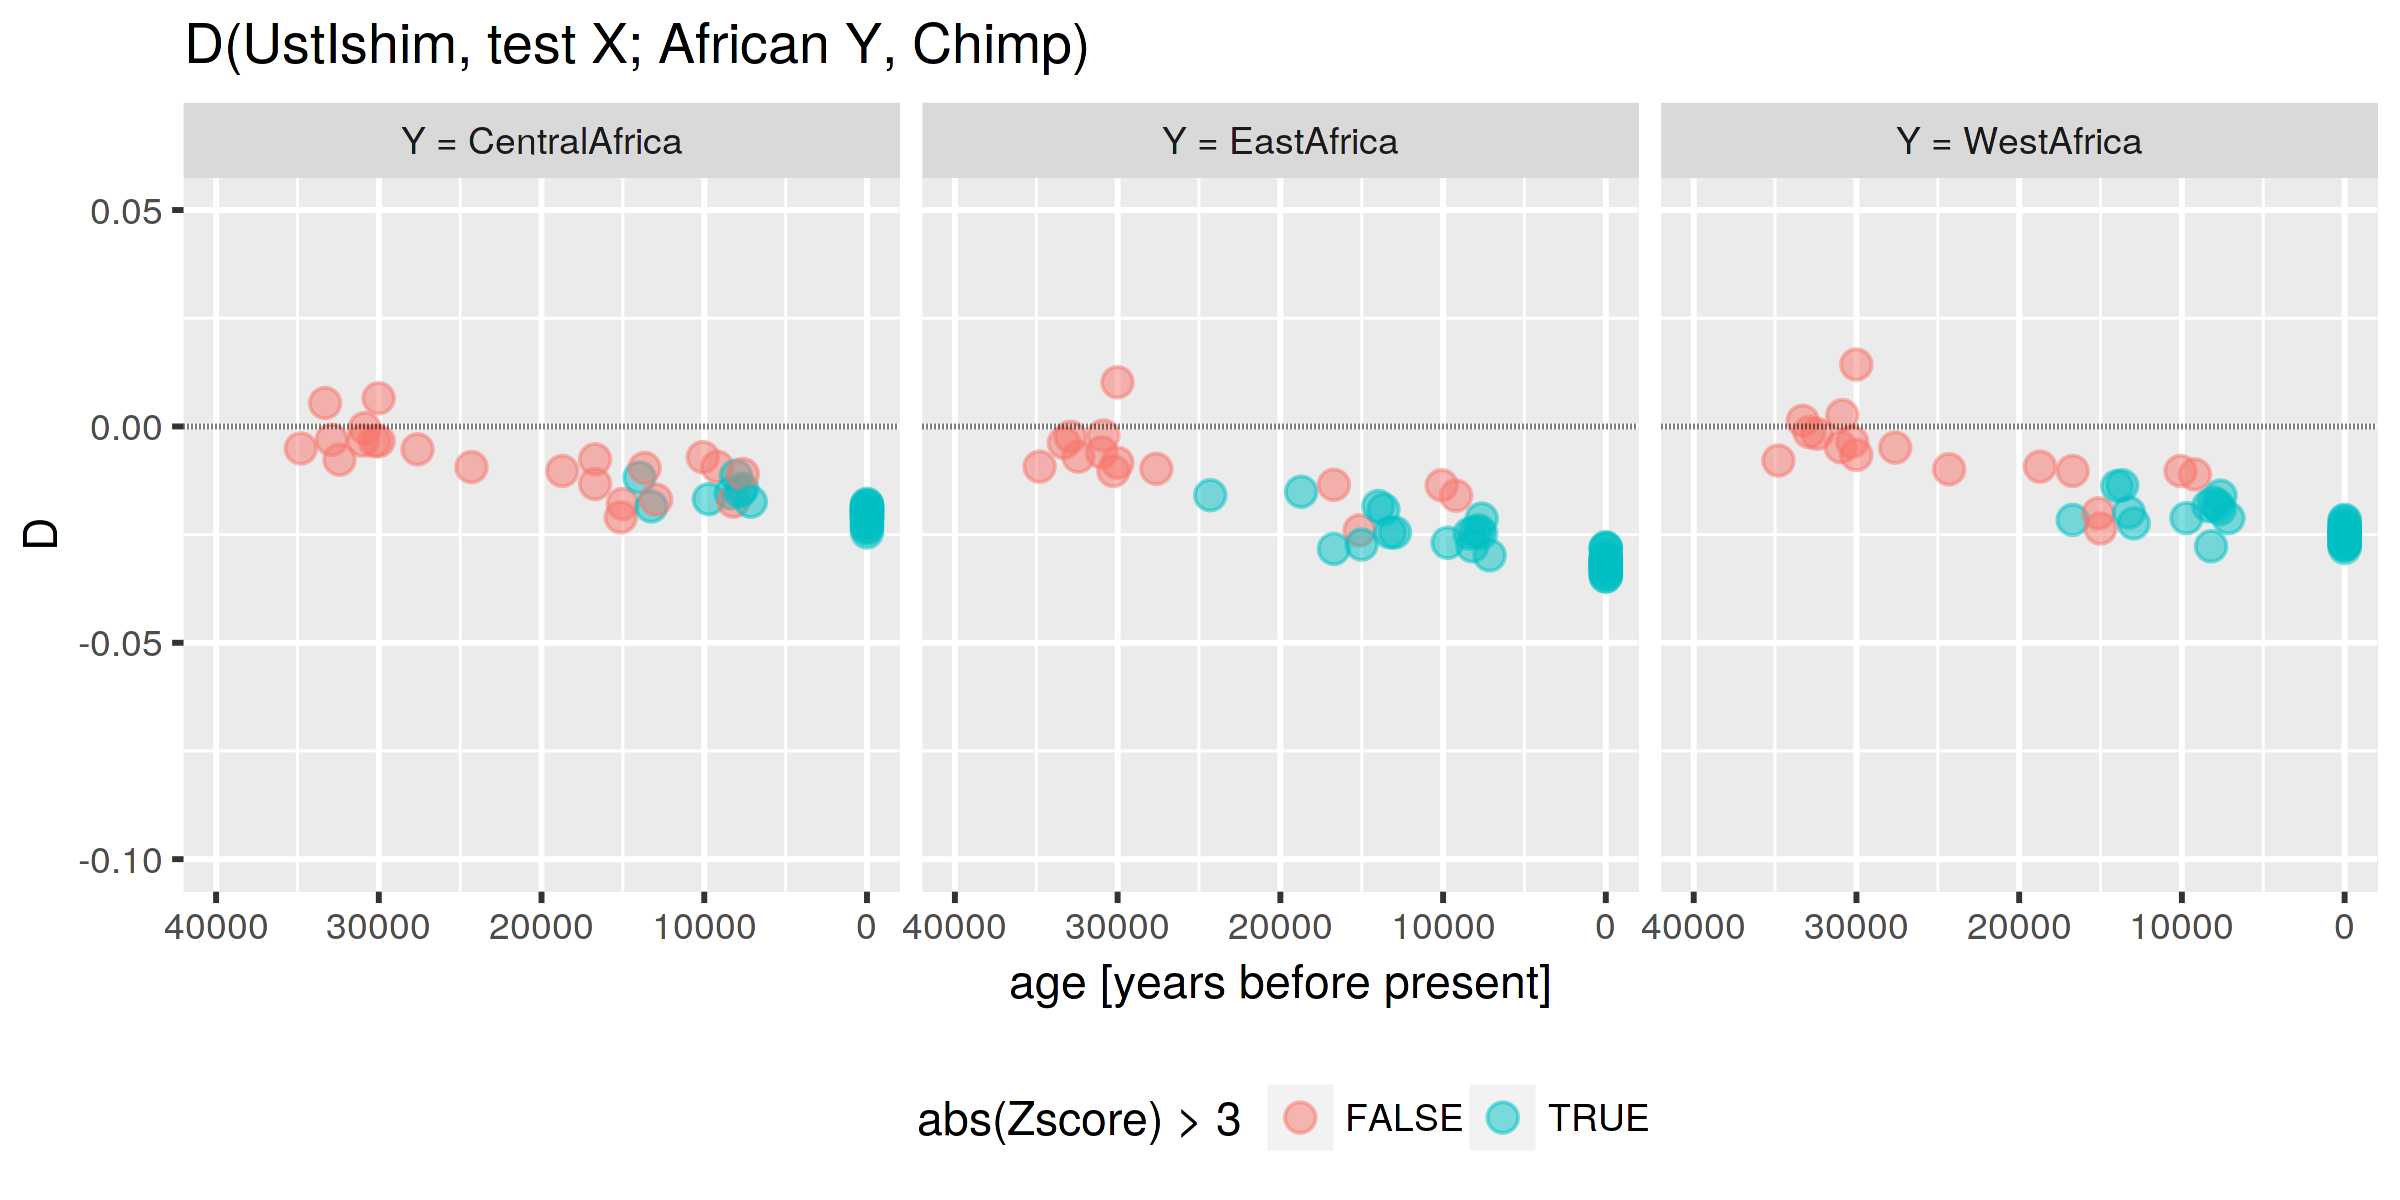

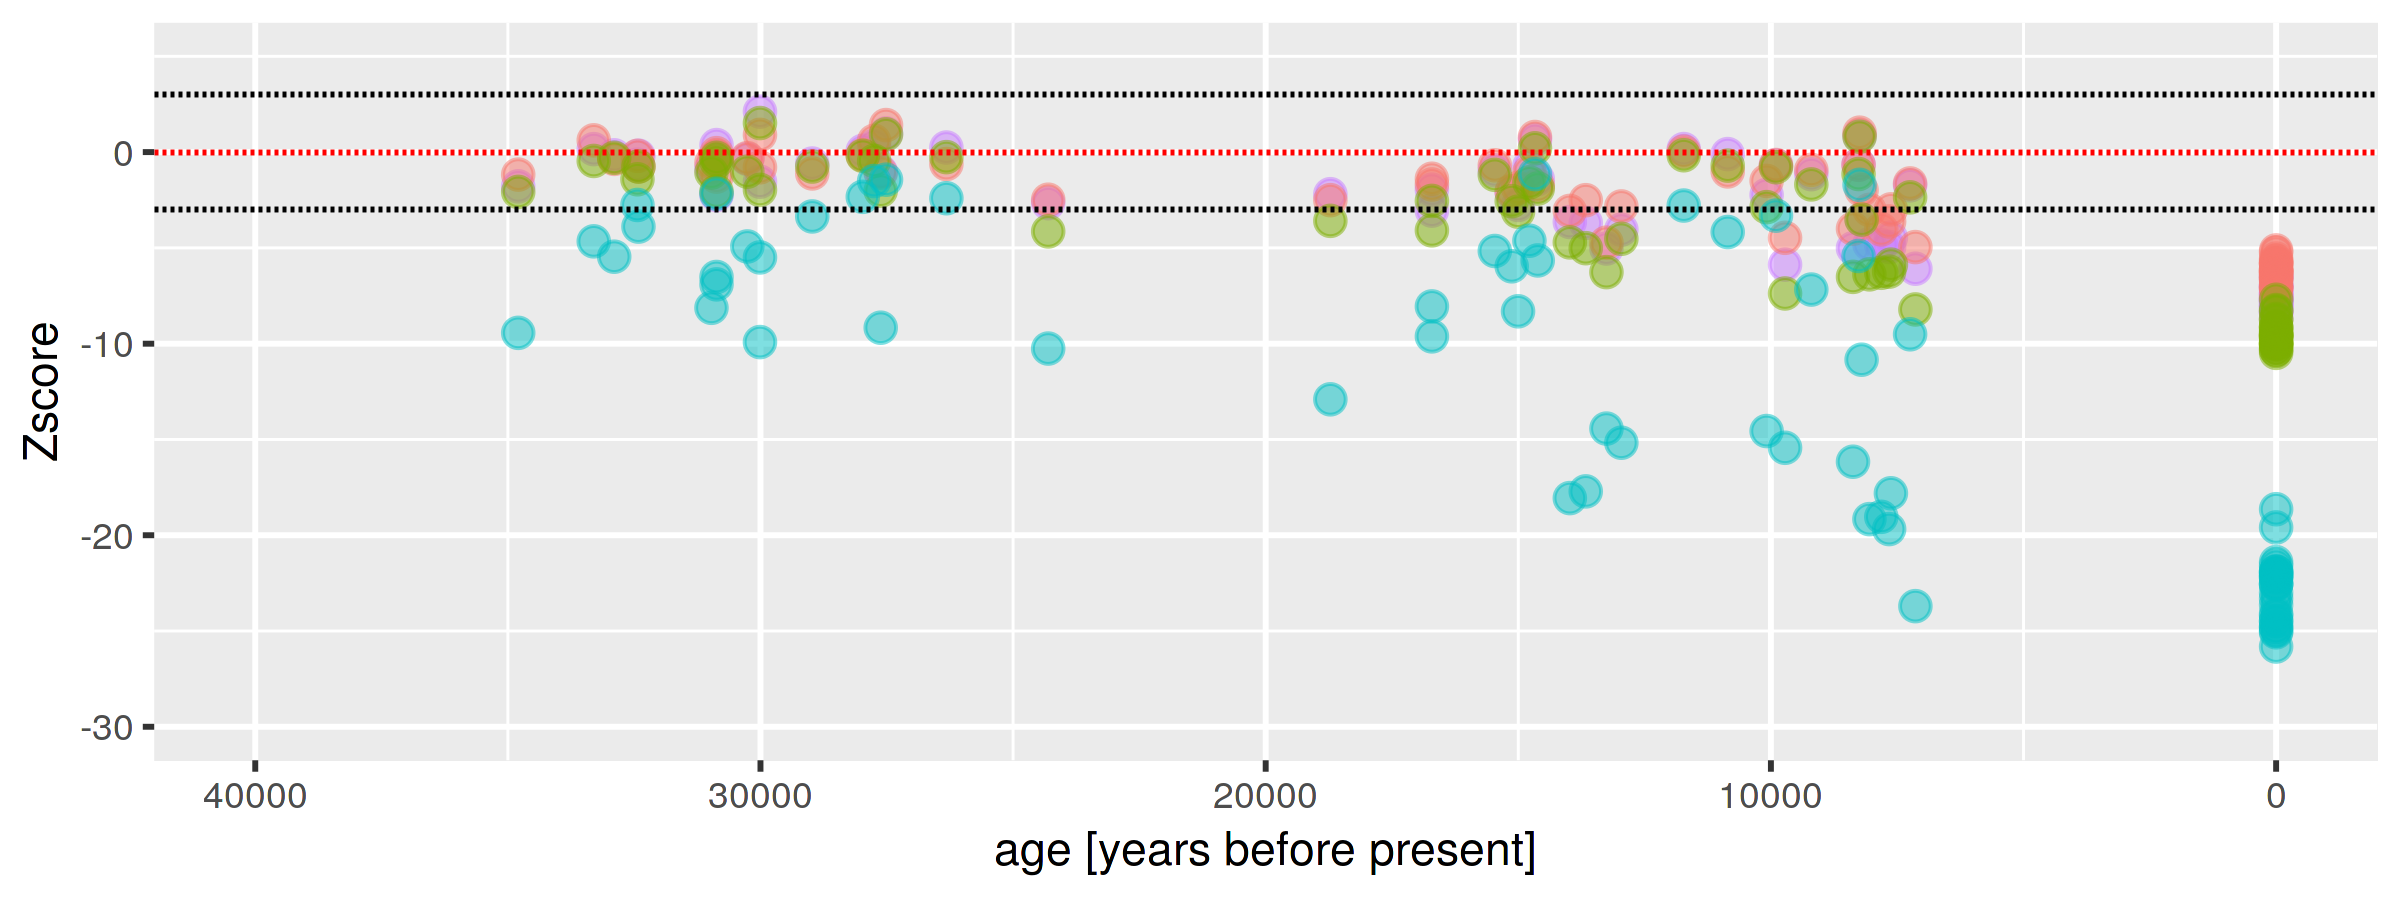

In [42]:
set_dim(4, 3, 300)
filter(df_affinity_chimp_ui, Y == "Oceania") %>% plot_z(ylim=c(-20, 20), title="D(UstIshim, test X; Papuans, Chimp)")

set_dim(8, 4, 300)
filter(df_affinity_chimp_ui, str_detect(Y, "Africa"), Y != "NorthAfrica") %>% 
filter(n_snps >= 50000) %>% plot_d(title="D(UstIshim, test X; African Y, Chimp)")

set_dim(8, 3, 300)
filter(df_affinity_chimp_ui, str_detect(Y, "Africa")) %>% plot_z(ylim=c(-30, 5))

## Ust-Ishim instead of Kostenki14 with Mbuti as an outgroup

In [224]:
present_day_Y <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "America"=filter(samples, pop == "America")$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Oceania"=filter(samples, pop == "Oceania")$name,
    "CentralAsiaSiberia"=filter(samples, pop == "CentralAsiaSiberia")$name,
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo"),
    "NorthAfrica"=c("Saharawi", "Mozabite")
)

In [225]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats_mbuti_ui <- vector(mode="list")
for (pop in names(present_day_Y)) {
    # calculate D statistics on the ancient individuals
    ancient <- qpDstat(W="UstIshim", X=ancient_X, Y=pop, Z="Mbuti",
                       prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))

    # calculate D statistics on the modern individuals
    modern <- qpDstat(W="UstIshim", X=modern_X, Y=pop, Z="Mbuti",
                      prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_affinity_Mbuti"))
    
    affinity_dstats_mbuti_ui[[pop]] <- bind_rows(ancient, modern)
}

In [226]:
# join Dstat results for ancient and present-day humans
df_affinity_mbuti_ui <- bind_rows(affinity_dstats_mbuti_ui) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(set="all", se=D / Zscore)

<font color="red">The shift upwards for present-day EUR might reflect test_X <-> Mbuti affinity because of the backflow. Also X and Oceanians might be forming a clade? Not sure if we know if Oceanians split off before or after UI's divergence.</font>

<font color="red">The observation that there is an increasing affinity to _all_ Africans over time pretty much invalidates all D statistics with an African in the last position.</font>

# Testing that central/west Afr. are outgroup to east Afr. + non-Africans

Ben had the following idea:

$D(\textrm{non-Afr},\textrm{Dinka},\textrm{west-or-centra-or-north-Afr},\textrm{Chimp})$

I tested that using all East Africans except Masai and Somali, which I excluded because of evidence of non-African admixture into east Africans (see [here](http://www.cell.com/cms/attachment/2108833685/2082649541/mmc6.xlsx) and also bellow). Otherwise the D(non-Afr, East Africa; Central Africa, Chimp) is obviously affected, because non-Africans and East Africans are drawn together (making the D go closer to 0).

In [112]:
africans <- list(
    "CentralAfrica"="Mbuti",
    "West+EastAfrica"=c(c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
                   c("Dinka", "BantuKenya", "Luhya", "Luo"))
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_Africans_WEAfr_merged"), africans)

africans <- list(
    "WestCentralAfrica"=c("Mbuti", "Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "EastAfrica"=c("Dinka", "BantuKenya", "Luhya", "Luo") # excluded "Masai", "Somali" (non-African backflow) - Table S6 in Pontus et al.

)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_Africans_WCAfr_merged"), africans)

africans <- list(
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "CentralAfrica"="Mbuti",
    "EastAfrica"=c("Dinka", "BantuKenya", "Luhya", "Luo") # excluded "Masai", "Somali" (non-African backflow) - Table S6 in Pontus et al.
)
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_Africans"), africans)

ancient_X <- filter(samples, pop == "EMH")$name
modern_X <- filter(samples, pop == "WestEurasia")$name

## all SNPs

In [81]:
african_dstat <- list()

In [82]:
african_dstat[["D(X, East Africa; West Africa, Chimp)"]] <-
    qpDstat(W=modern_X, X="EastAfrica", Y="WestAfrica", Z="Chimp", prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans")) %>%
    mutate(se=D / Zscore, setup="D(X, East Africa; West Africa, Chimp)")

In [83]:
african_dstat[["D(X, East Africa; CentralAfrica, Chimp)"]] <-
    qpDstat(W=modern_X, X="EastAfrica", Y="CentralAfrica", Z="Chimp", prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans")) %>%
    mutate(se=D / Zscore, setup="D(X, East Africa; CentralAfrica, Chimp)")

In [84]:
african_dstat[["D(X, WestAfrica; CentralAfrica, Chimp)"]] <-
    qpDstat(W=modern_X, X="WestAfrica", Y="CentralAfrica", Z="Chimp",  prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans")) %>%
    mutate(se=D / Zscore, setup="D(X, WestAfrica; CentralAfrica, Chimp)")

In [87]:
african_dstat[["D(X, West+EastAfrica; CentralAfrica, Chimp)"]] <-
    qpDstat(W=modern_X, X="West+EastAfrica", Y="CentralAfrica", Z="Chimp", prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans_WEAfr_merged")) %>%
    mutate(se=D / Zscore, setup="D(X, West+EastAfrica; CentralAfrica, Chimp)")

In [107]:
african_dstat[["D(X, EastAfrica; WestCentralAfrica, Chimp)"]] <-
    qpDstat(W=modern_X, X="EastAfrica", Y="WestCentralAfrica", Z="Chimp", prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".SGDP_Africans_WCAfr_merged")) %>%
    mutate(se=D / Zscore, setup="D(X, EastAfrica; WestCentralAfrica, Chimp)")

In [108]:
df_african_dstat <- bind_rows(african_dstat)

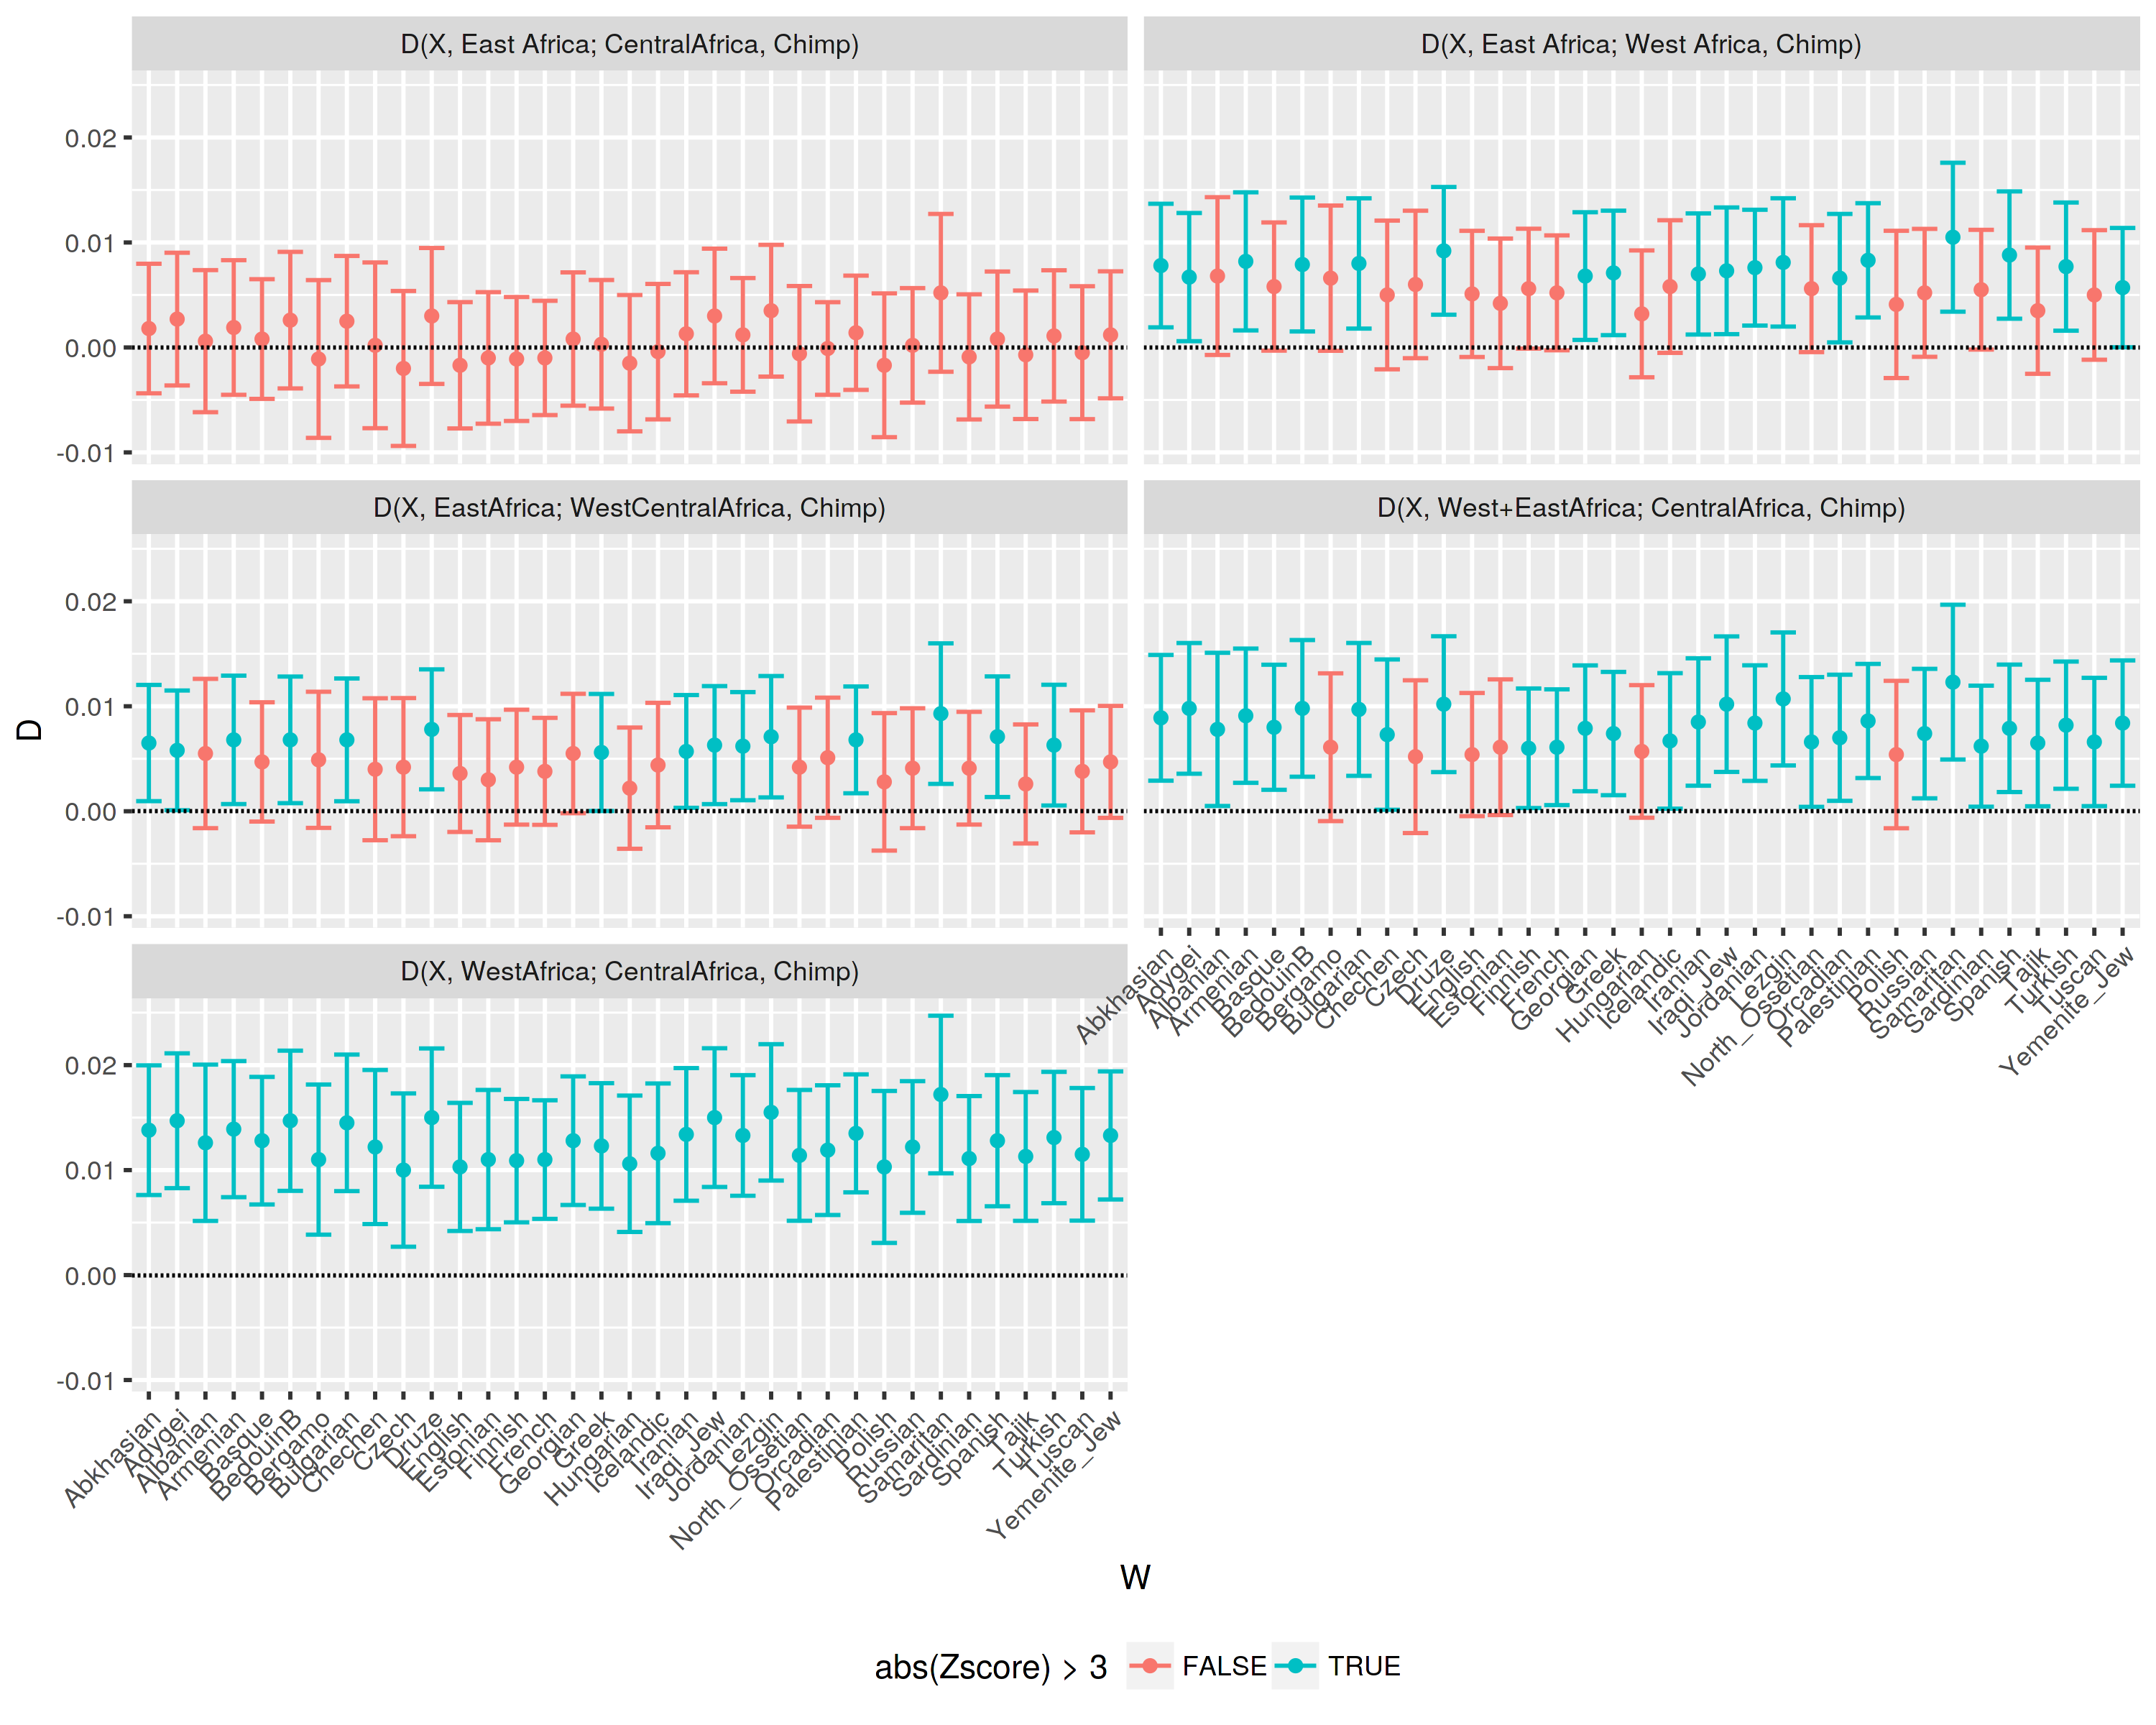

In [111]:
set_dim(10, 8, 300)

df_african_dstat %>%
ggplot(aes(W, D, color=abs(Zscore) > 3)) +
    geom_point() +
    geom_errorbar(aes(ymin=D - 3 * se, ymax=D + 3 * se)) +
    geom_hline(yintercept=0, linetype=2) +
    theme(legend.position="bottom", axis.text.x=element_text(hjust=1, angle=45)) +
    facet_wrap(~ setup, nrow=4)

<font color="red">
   
# TODO How do these plots look like for D(X, West Africa; Central Africa, Chimp)?

Do non-Africans + West Africans also form a clade vs Central Africa?

</font>

# Do central and west Afr. really form a clade, with east Afr. as an outgroup?

This is the basic assumption of the f4 ratio calculation from the Ice Age paper.

$D(\textrm{west African},\textrm{central African},\textrm{east African},\textrm{Chimp})$

In [113]:
wc_vs_east <- qpDstat(W=africans$WestAfrica, X=africans$CentralAfrica, Y=africans$EastAfrica, Z="Chimp", prefix=EIGENSTRAT_PREFIX)

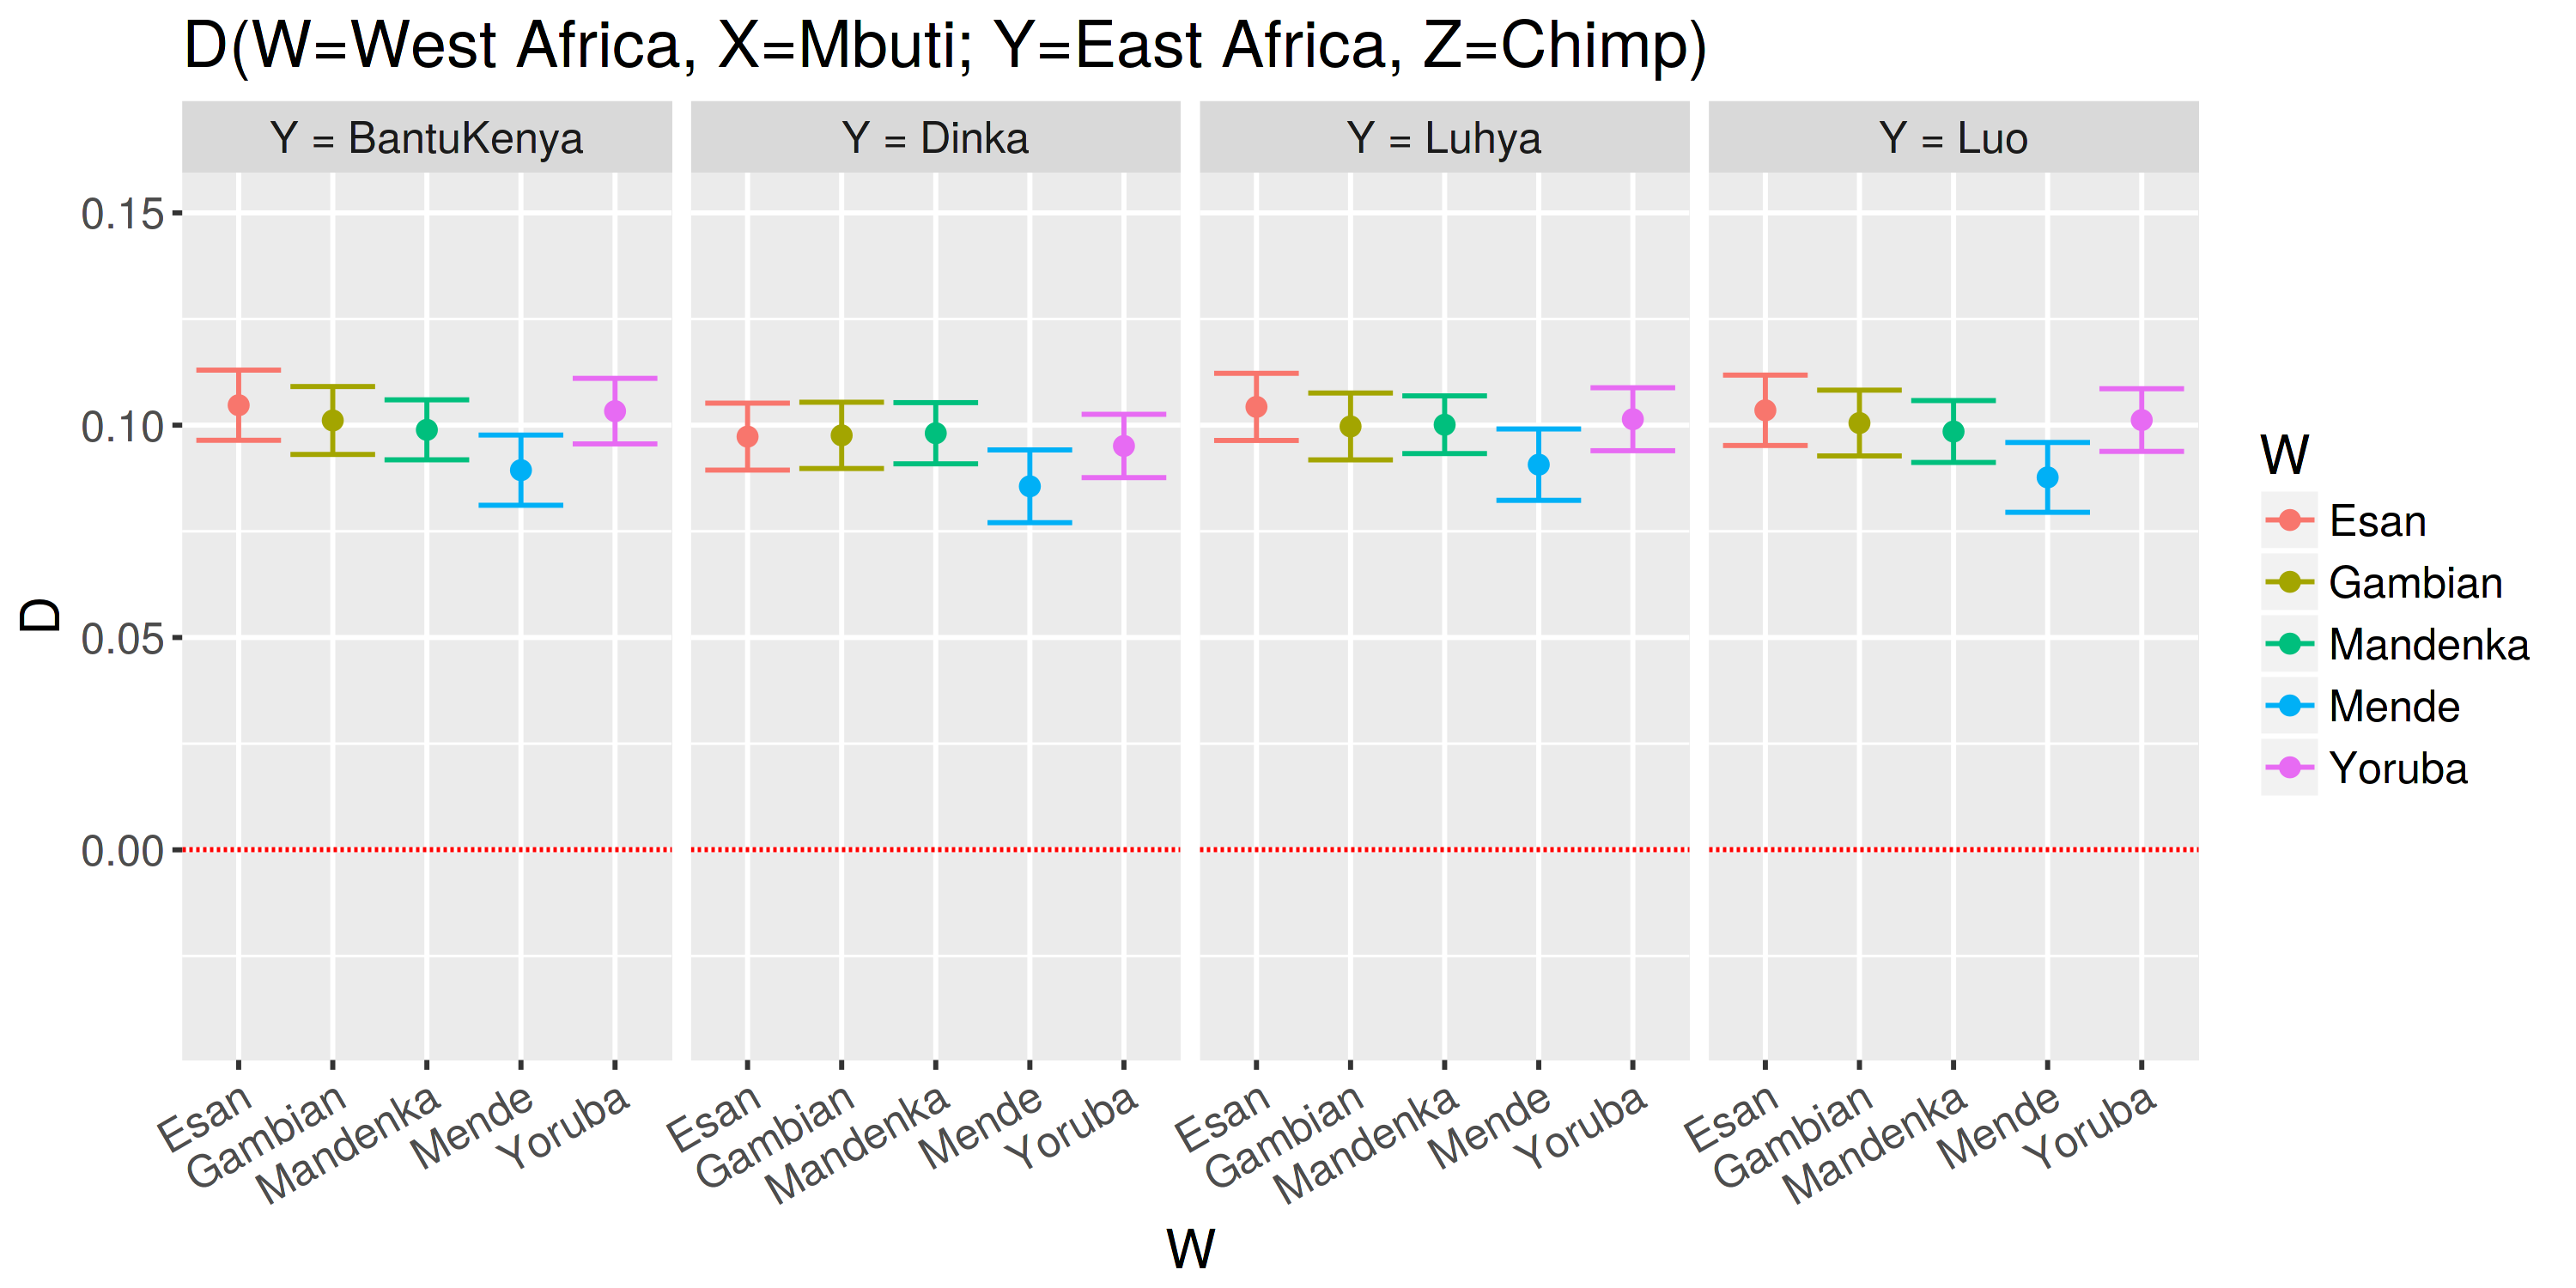

In [188]:
set_dim(10, 5, 300)

wc_vs_east %>% mutate(se=D / Zscore) %>% mutate(Y=paste("Y =", Y)) %>% 
ggplot(aes(W, D, color=W)) +
    geom_point(size=2) + 
    geom_hline(yintercept=0, linetype=2, color="red") +
    geom_errorbar(aes(ymin=D - 3 * se, ymax=D + 3 * se)) +
    facet_grid(. ~ Y) + ylim(-0.04, 0.15) +
    theme(legend.position="right", text=element_text(size=15), axis.text.x=element_text(angle=30, hjust=1)) +
    ggtitle(paste0("D(W=West Africa, X=Mbuti; Y=East Africa, Z=Chimp)"))

In [136]:
we_vs_central <- qpDstat(W=africans$WestAfrica, X=africans$EastAfrica, Y=africans$CentralAfrica, Z="Chimp", prefix=EIGENSTRAT_PREFIX)

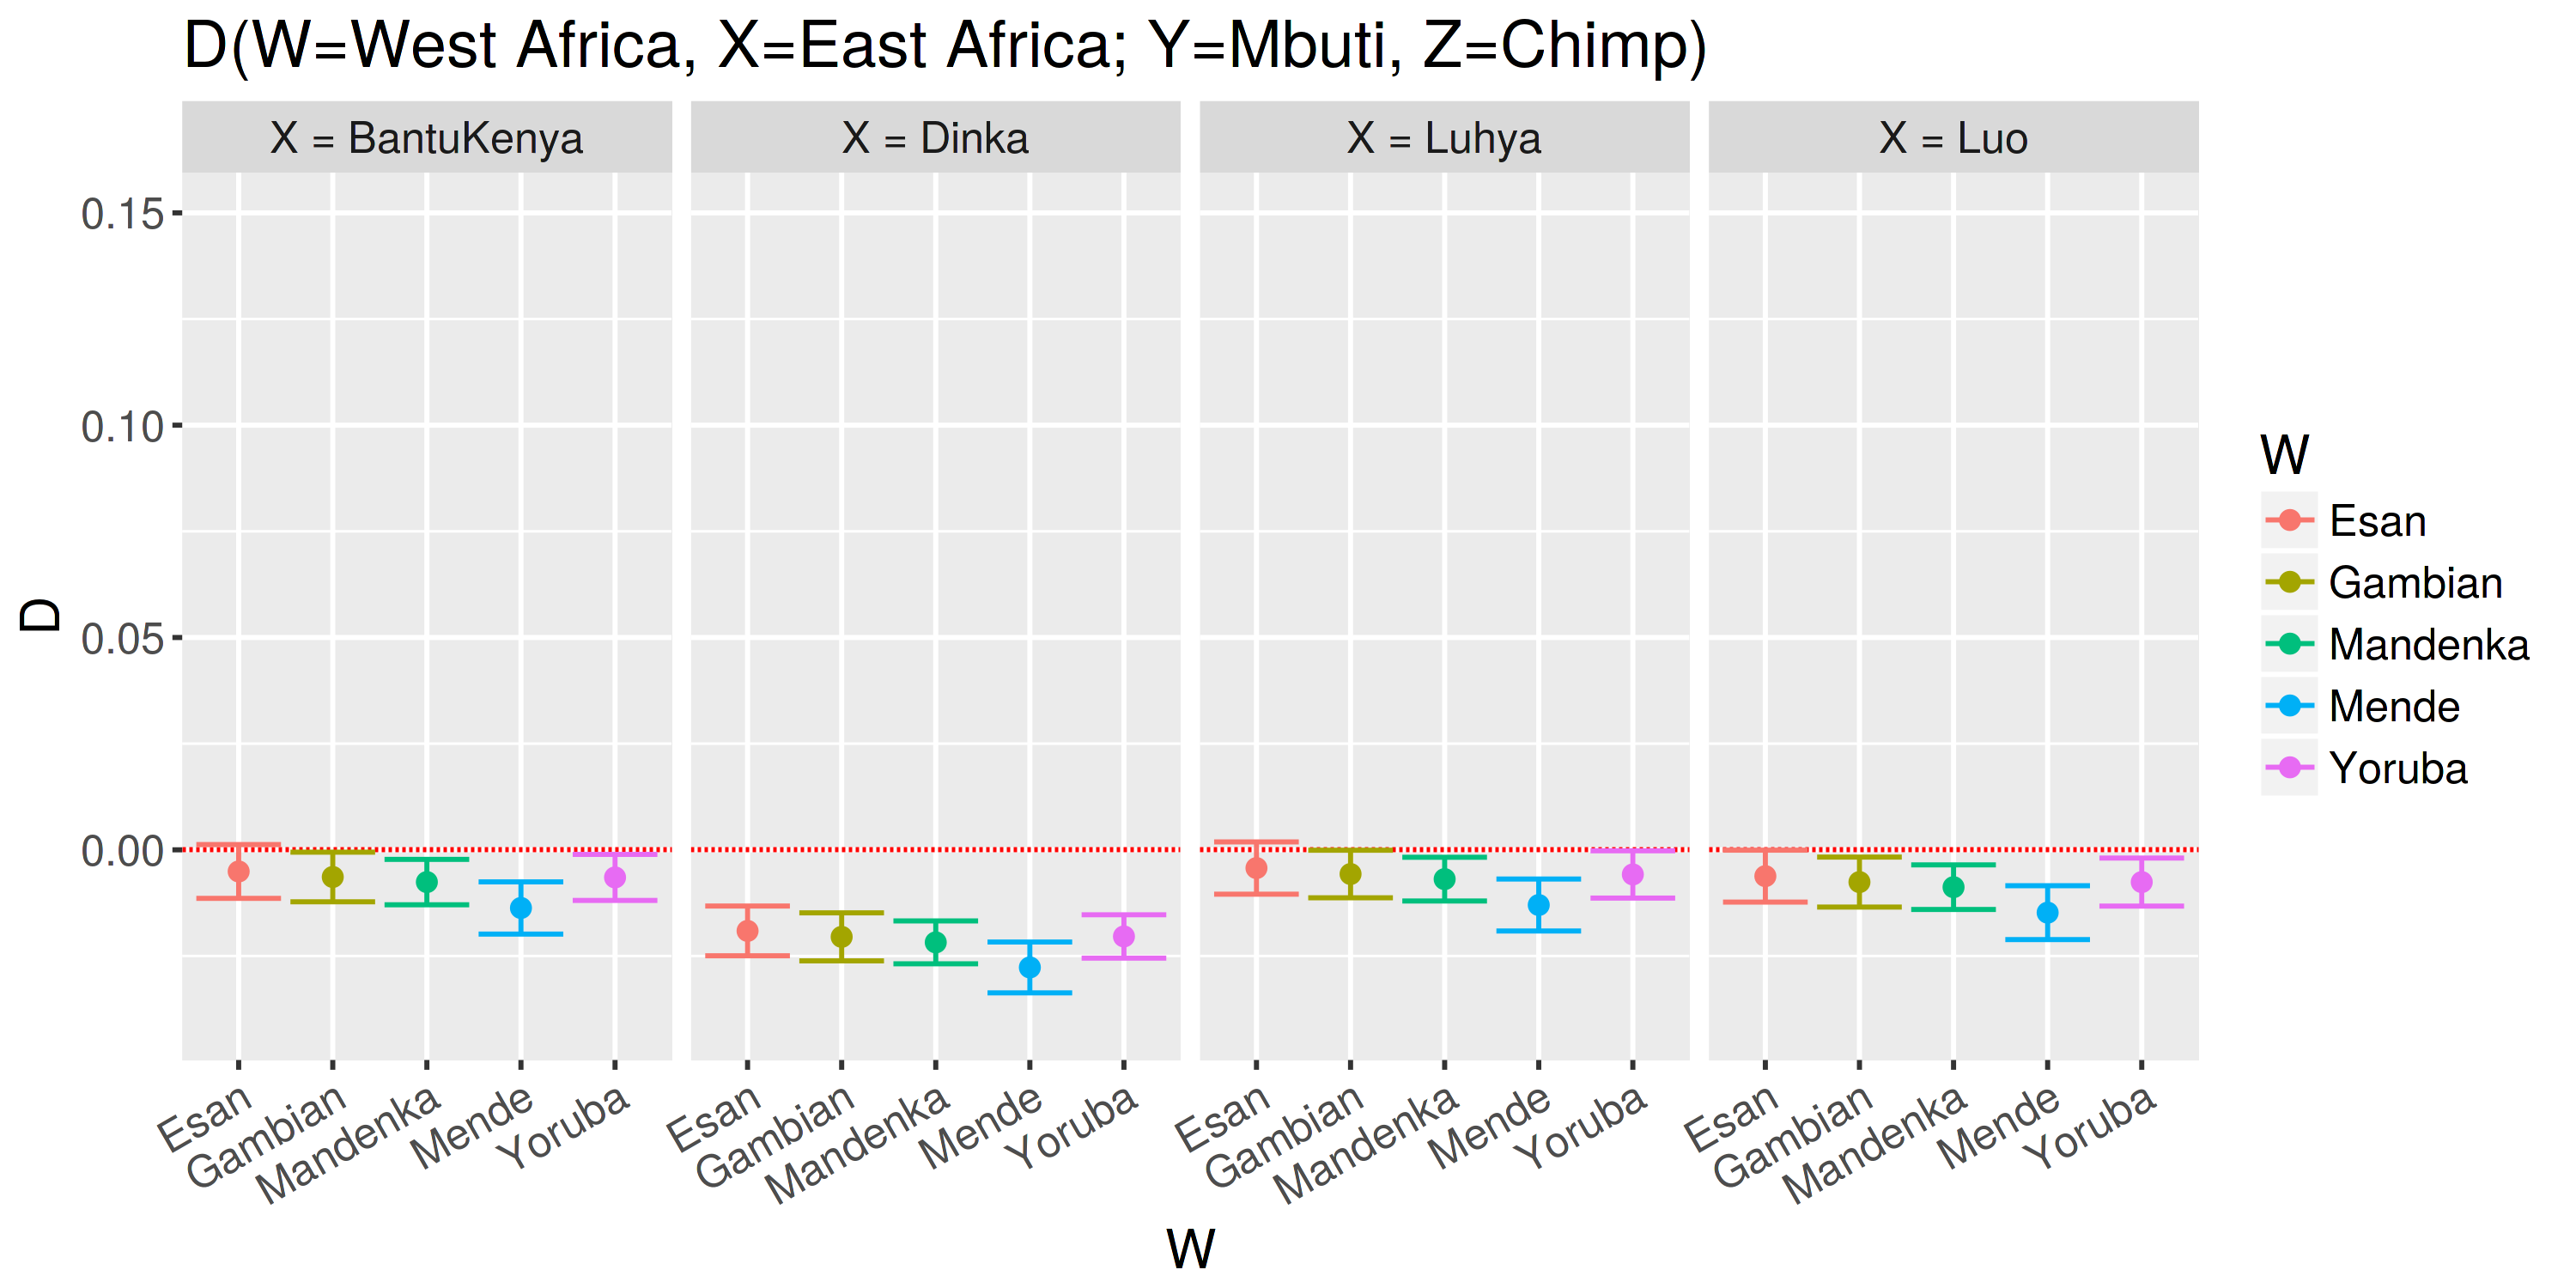

In [189]:
set_dim(10, 5, 300)

we_vs_central %>% mutate(se=D / Zscore) %>% mutate(X=paste("X =", X)) %>% 
ggplot(aes(W, D, color=W)) +
    geom_point(size=2) + 
    geom_hline(yintercept=0, linetype=2, color="red") +
    geom_errorbar(aes(ymin=D - 3 * se, ymax=D + 3 * se)) +
    facet_grid(. ~ X) + ylim(-0.04, 0.15) +
    theme(legend.position="right", text=element_text(size=15), axis.text.x=element_text(angle=30, hjust=1)) +
    ggtitle(paste0("D(W=West Africa, X=East Africa; Y=Mbuti, Z=Chimp)"))

**Conclusion**: West and Central Africans do **not** form a clade with respect to East Africans! If they were, we would expect D ~ 0. This directly violates the Ice Age f4 ratio assumption!

# Testing Eurasian backflow into Africans

Which present-day non-Africans show evidence of admixture with Africans?

$D(\textrm{Eurasian 1},\textrm{Eurasian 2},\textrm{test African},\textrm{Chimp})$

In [257]:
non_africans <- list(
    "NearEast"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "EastAsia"=filter(samples, pop == "EastAsia")$name,
    "SouthAsia"=filter(samples, pop == "SouthAsia")$name,
    "Europe"=filter(samples, pop == "WestEurasia", !str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name
)

In [258]:
all_africans <- list(
    "WestAfrica"=c("Esan", "Gambian", "Mandenka", "Mende", "Yoruba"),
    "EastAfrica"=c("Dinka", "BantuKenya", "Masai", "Somali", "Luhya", "Luo")
    #"NorthAfrica"=c("Saharawi", "Mozabite"),
    #"CentralAfrica"="Mbuti"
)

In [259]:
merge_pops(file=IND_FILE, modified_file=paste0(IND_FILE, ".SGDP_whole_nonafr_pops"), non_africans)

In [260]:
backflow_dstats <- data.frame()

for (pop1 in names(non_africans)) {
    for (pop2 in setdiff(names(non_africans), pop1)) {
        backflow_dstats <- qpDstat(W=pop1, X=pop2, Y=unlist(all_africans), Z="Chimp",
                                   prefix=EIGENSTRAT_PREFIX,
                                   ind=paste0(IND_FILE, ".SGDP_whole_nonafr_pops")) %>%
                           bind_rows(backflow_dstats)
    }
}

Negative values - "point population closer than the facet population", positive value - "facet population closer than point population".

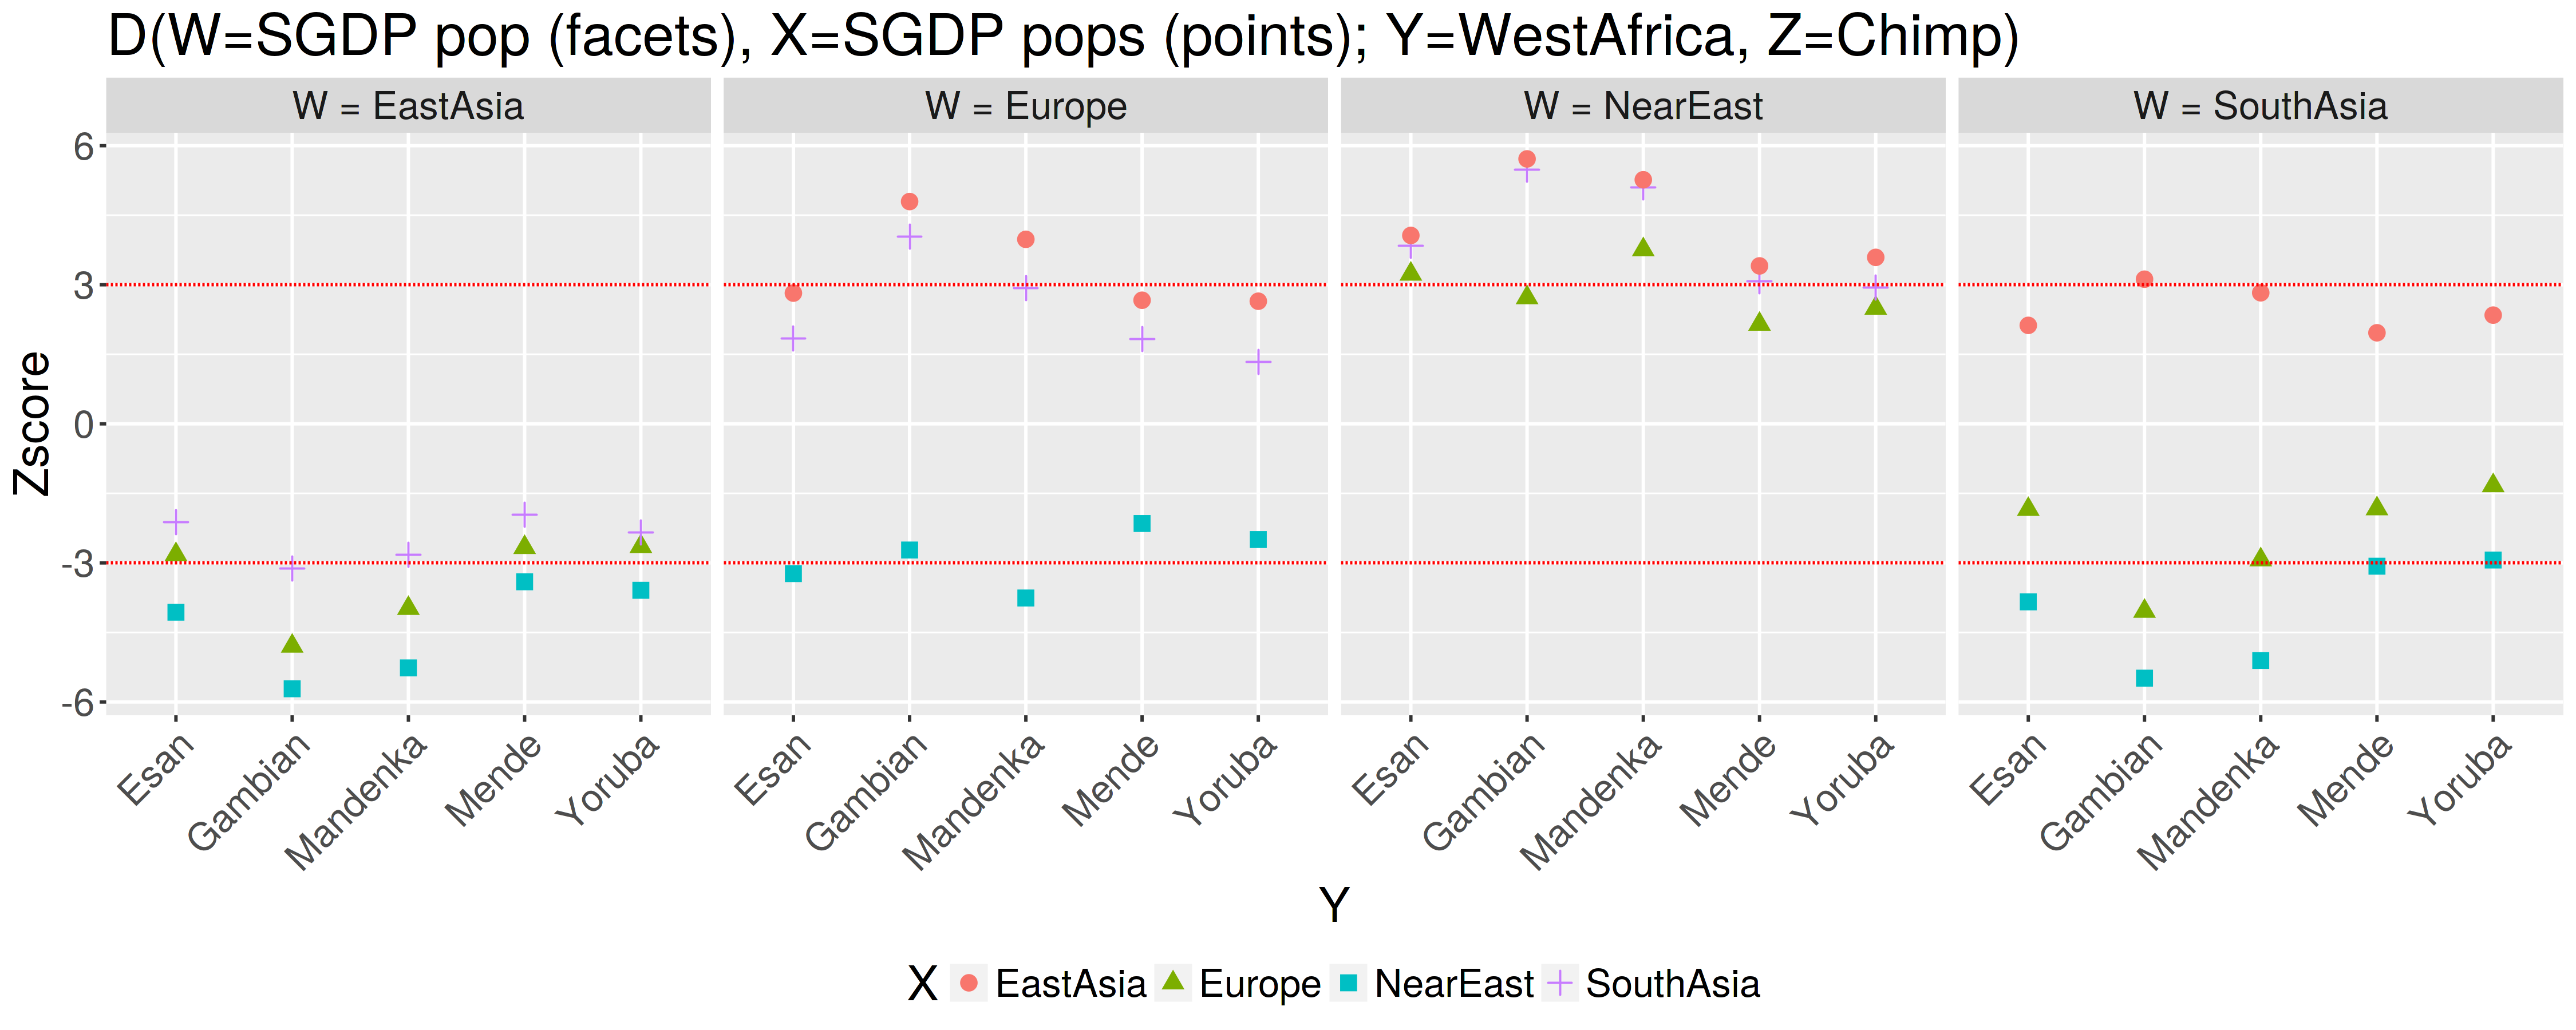

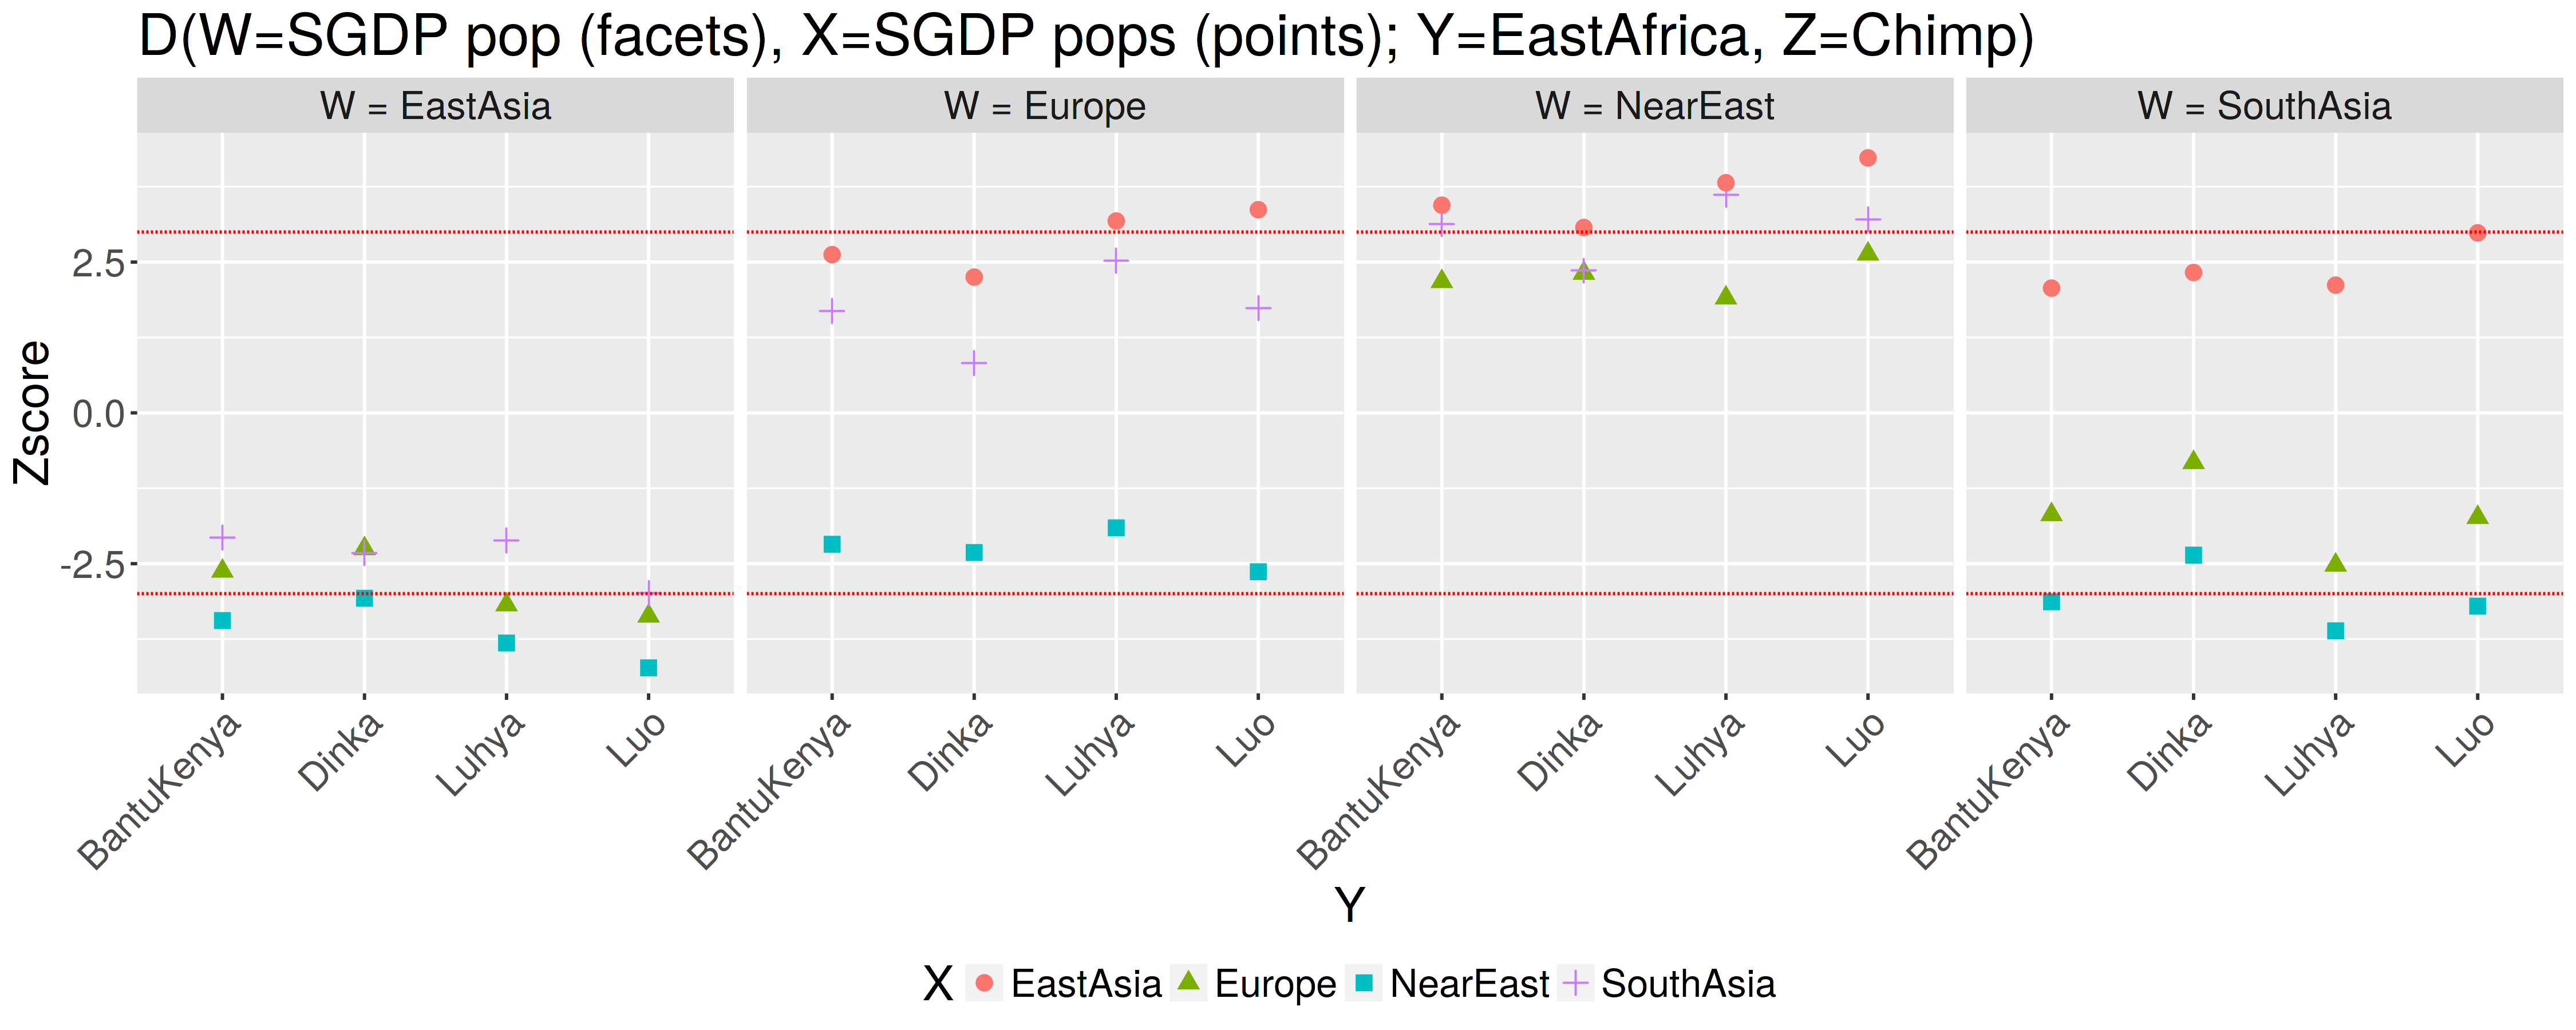

In [244]:
set_dim(15, 6, 300)

for (afr in c("WestAfrica", "EastAfrica")) {

    backflow_dstats %>% filter(W != "Oceania", X != "Oceania", !Y %in% c("Masai", "Somali"), Y %in% all_africans[[afr]]) %>% 
    mutate(W=paste0("W = ", W), se=D / Zscore) %>%
    {
    print(ggplot(., aes(Y, Zscore, color=X, shape=X)) +
        geom_point(size=3) +
        geom_hline(yintercept=c(-3, 3), linetype=2, color="red") +
        theme(text=element_text(size=20), axis.text.x=element_text(angle=45, hjust=1), legend.position="bottom") +
        facet_grid(. ~ W) +
        ggtitle(paste0("D(W=SGDP pop (facets), X=SGDP pops (points); Y=", afr, ", Z=Chimp)")))
    }
}

<font color="red">We see this significant attraction of Near East with Europe over time. Can we somehow try to estimate how much would Near Easterners (farmers?) contribute to present-day Europeans over time? How do we reconcile this with the dilution problem? We don't really see a decrease in Nea. over time (definitely not to an extent that might explain the differences  of N in EUR vs ASN. Is it likely that Near Easterners diluted Nea alleles?</font>

## Estimating the proportions of Near East 

D statistic such as the one used above can be used as a significance test of potential admixture, but does not reveal the actual admixture _proportions_. Therefore, after finding a suggestive evidence of a growing affinity towards Near East, we were interested if there is also an increasing proportion of Near East ancestry (and potentially towards basal Eurasian ancestry?) over time until the present.

We did this by estimating the proportion of Near East ancestry in each EMH and present-day SGDP European (which should give us an idea about the rate of dilution that potentially happened).

<font color="red">Some info on Near East prop estimation can be found in the supplement of the 3-component paper by Lazaridis (page 91).</font>

To get an estimate of the Near East ancestry in an individual X, we used the following f4 ratio: $\frac{f_4(\textrm{present-day Near East},\textrm{ Mbuti}; \textrm{ test individual X},\textrm{ Vestonice cluster})}{f_4(\textrm{present-day Near East},\textrm{ Mbuti};\textrm{ ancient Near East},\textrm{ Vestonice cluster})}$

In a terminology used by an f4 ratio scheme by @patterson_ancient_2012:

* A = subset of present-day Near Easterners from the SGDP panel
* B = subset of ancient Near Easterners from @lazaridis_genomic_2016 (Levant and Natufians, 8-12ky old)
* C = Vestonice cluster, cluster of ~ 20ky old Europeans
* O = Mbuti
* X = test individual.

![](img/mailund_f4_tree.png)

Merge ancient Near Eastern individuals into an "ancient_NearEast" metapopulation, do a similar thing with present-day Near Easterners.

In [463]:
library(parallel)

In [464]:
to_merge <- list(
    Vestonice_cluster=c("Pavlov1", "Vestonice43", "Ostuni1", "Ostuni2", "Vestonice14", "Vestonice16", "Vestonice15", "Vestonice13")
)

In [465]:
merge_pops(IND_FILE, paste0(IND_FILE, ".Vestonice_cluster"), to_merge)

In [466]:
ancient_Europe <- setdiff(filter(samples, pop == "EMH")$name, c(c("UstIshim", "Kostenki14", "Oase1"), to_merge[["Vestonice_cluster"]]))
modern_Europe <- filter(samples, pop == "WestEurasia", !name %in% present_day_Y[["NearEast"]])$name

In [467]:
present_NearEast <- c("Yemenite_Jew", "Jordanian", "Samaritan", "BedouinB", "Palestinian")

In [468]:
near_east_proportion <- mclapply(mc.cores=length(present_NearEast), present_NearEast, function(pne) {

bind_rows(
    qpF4ratio(X=c(ancient_Europe, modern_Europe),
              A=pne,
              B="Levant_N", C="Vestonice_cluster", O="Mbuti",
              prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".Vestonice_cluster")),
    qpF4ratio(X=c(ancient_Europe, modern_Europe),
              A=pne,
              B="Natufian", C="Vestonice_cluster", O="Mbuti",
              prefix=EIGENSTRAT_PREFIX, ind=paste0(IND_FILE, ".Vestonice_cluster"))
)

}) %>% bind_rows %>% 
    inner_join(samples, by=c("X"="name")) %>%
    inner_join(snp_counts_f4, by=c("X"="name"))

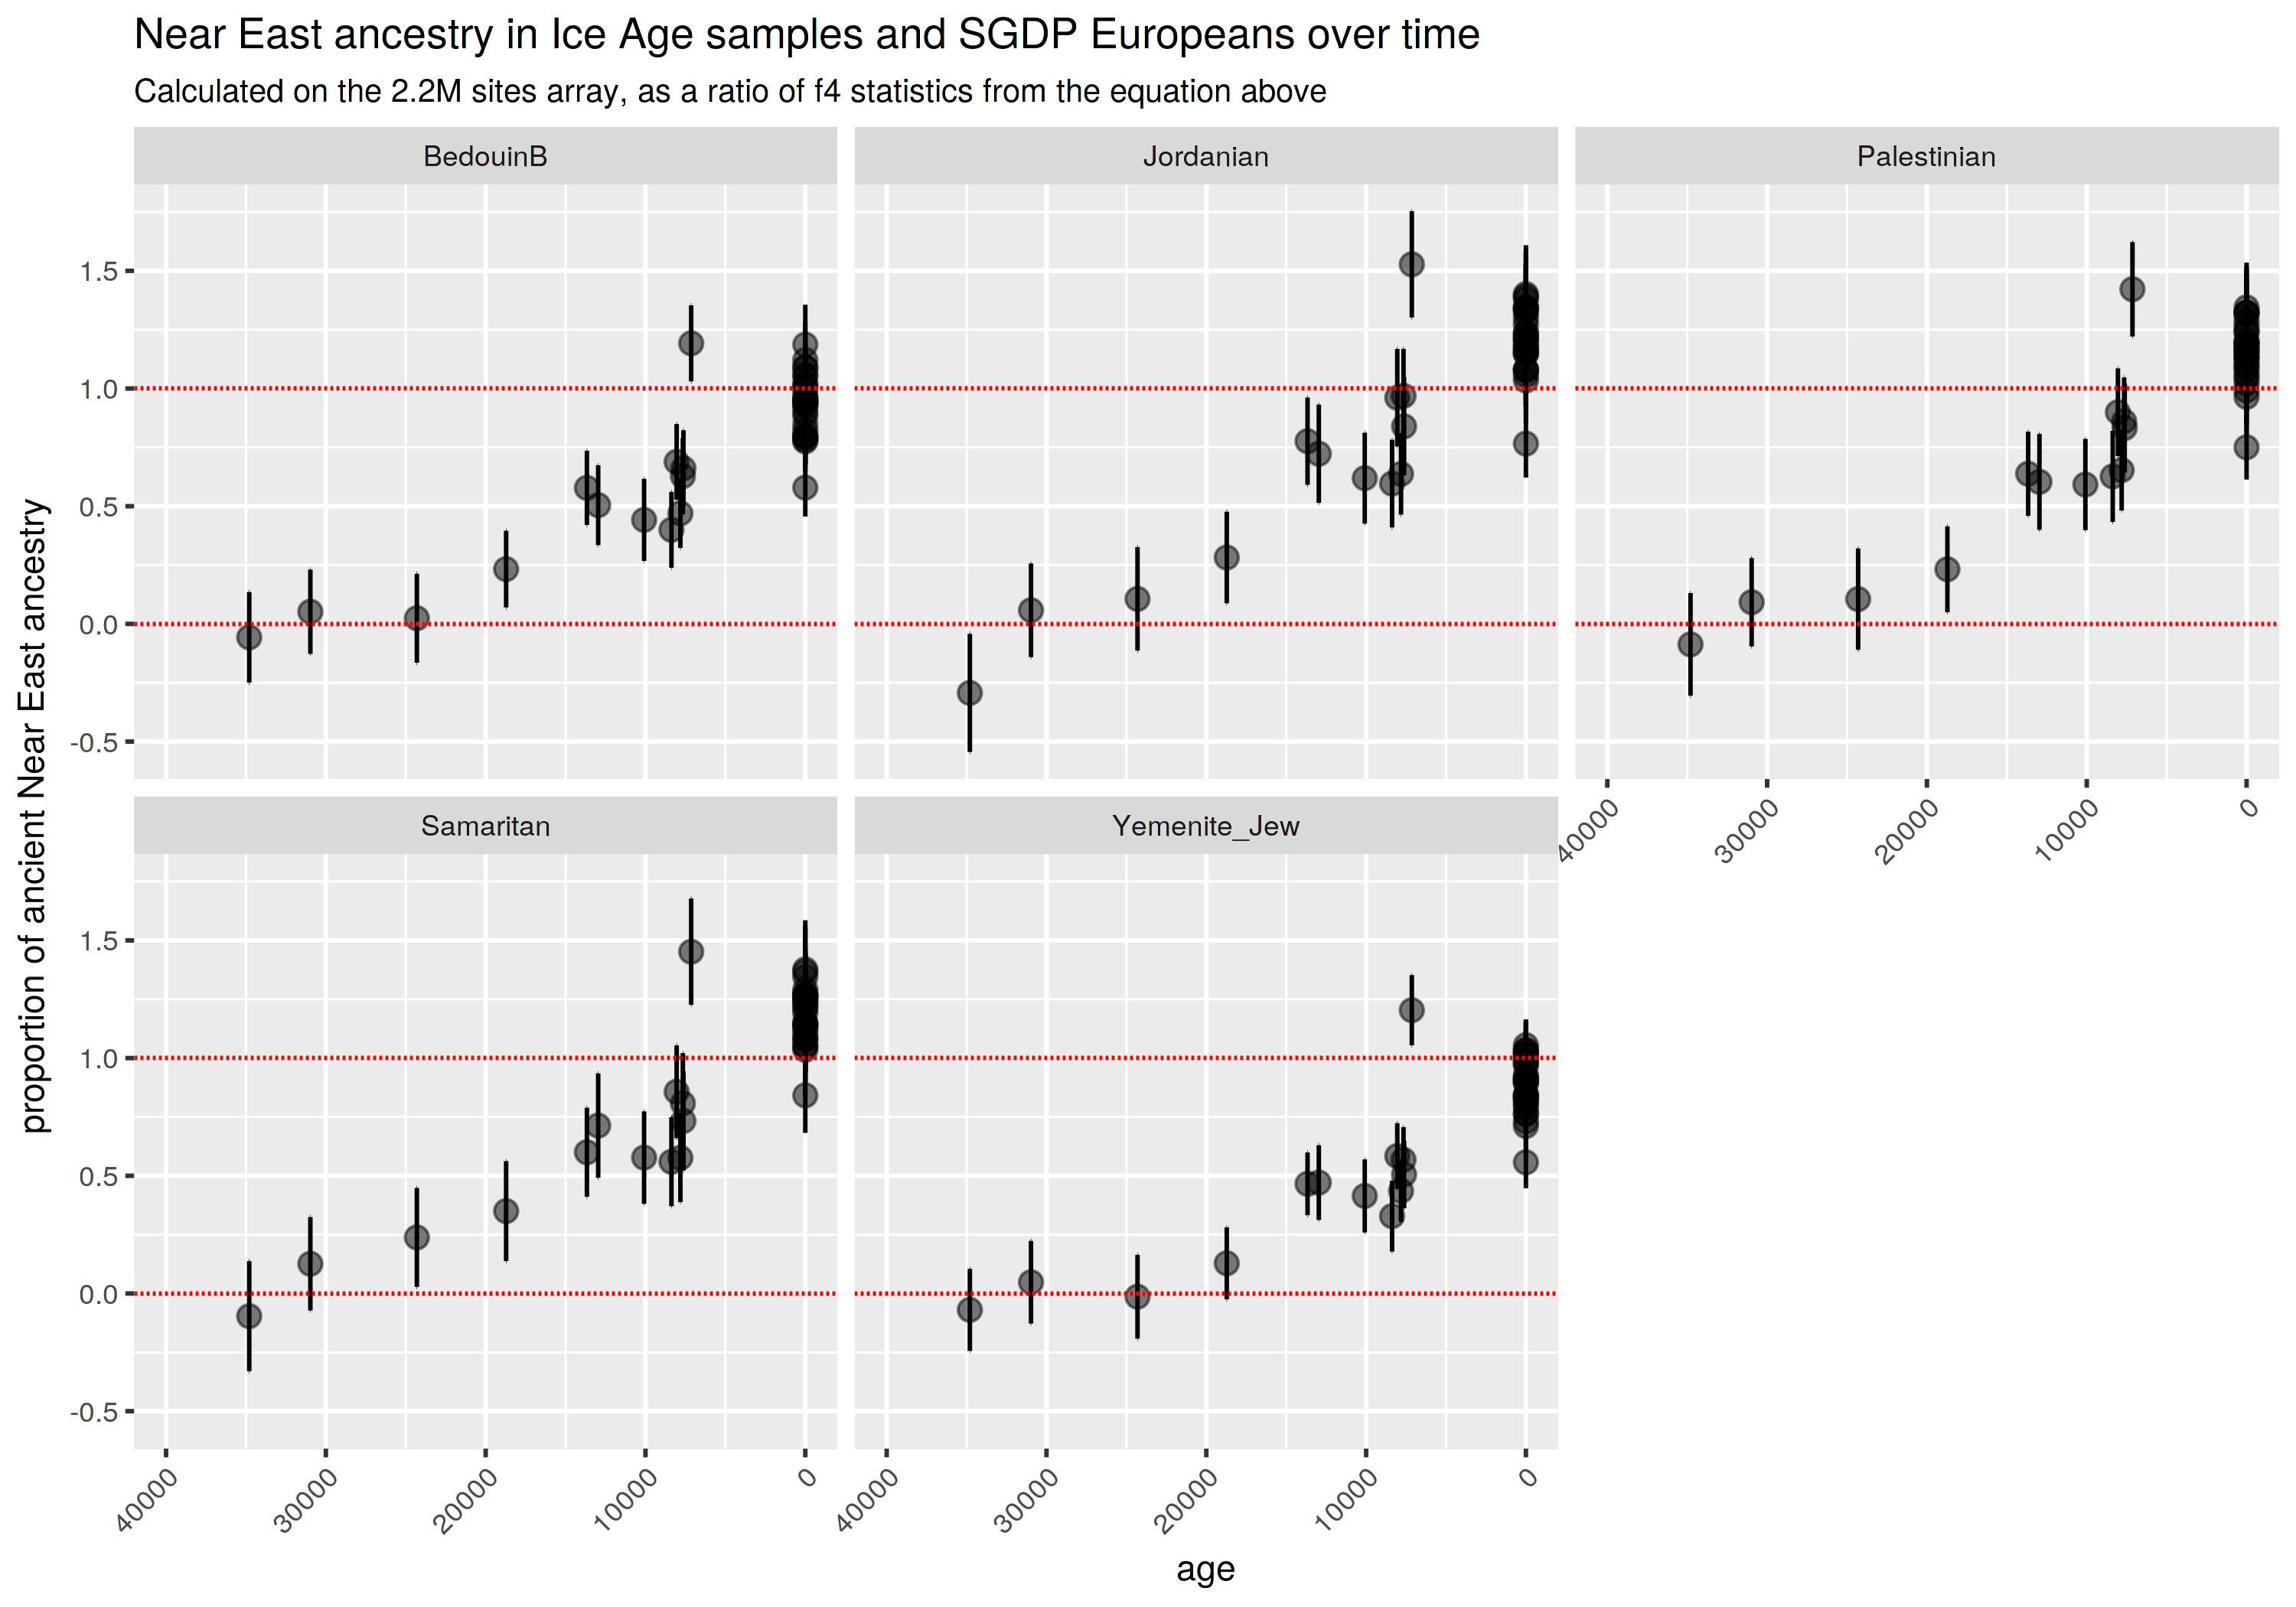

In [104]:
options(repr.plot.width=10, repr.plot.height=7)

## F4 ratios of Near eastern ancestry in present-day and UP humans over time
near_east_proportion %>% filter(B == "Levant_N") %>% filter(snp_count > 150000) %>% 
filter(!X %in% non_udg_samples) %>%
ggplot(aes(age, alpha)) +
    geom_point(size=3, alpha=1/2) +
    geom_errorbar(aes(ymin=alpha - 2 * stderr, ymax=alpha + 2 * stderr)) +
    geom_hline(yintercept=c(0, 1), linetype=2, color="red") +
    facet_wrap(~ A) +
    xlim(40000, 0) + labs(y="proportion of ancient Near East ancestry") +
    theme(legend.position="none", axis.text.x=element_text(angle=45, hjust=1)) +
    ggtitle("Near East ancestry in Ice Age samples and SGDP Europeans over time",
            subtitle="Calculated on the 2.2M sites array, as a ratio of f4 statistics from the equation above")

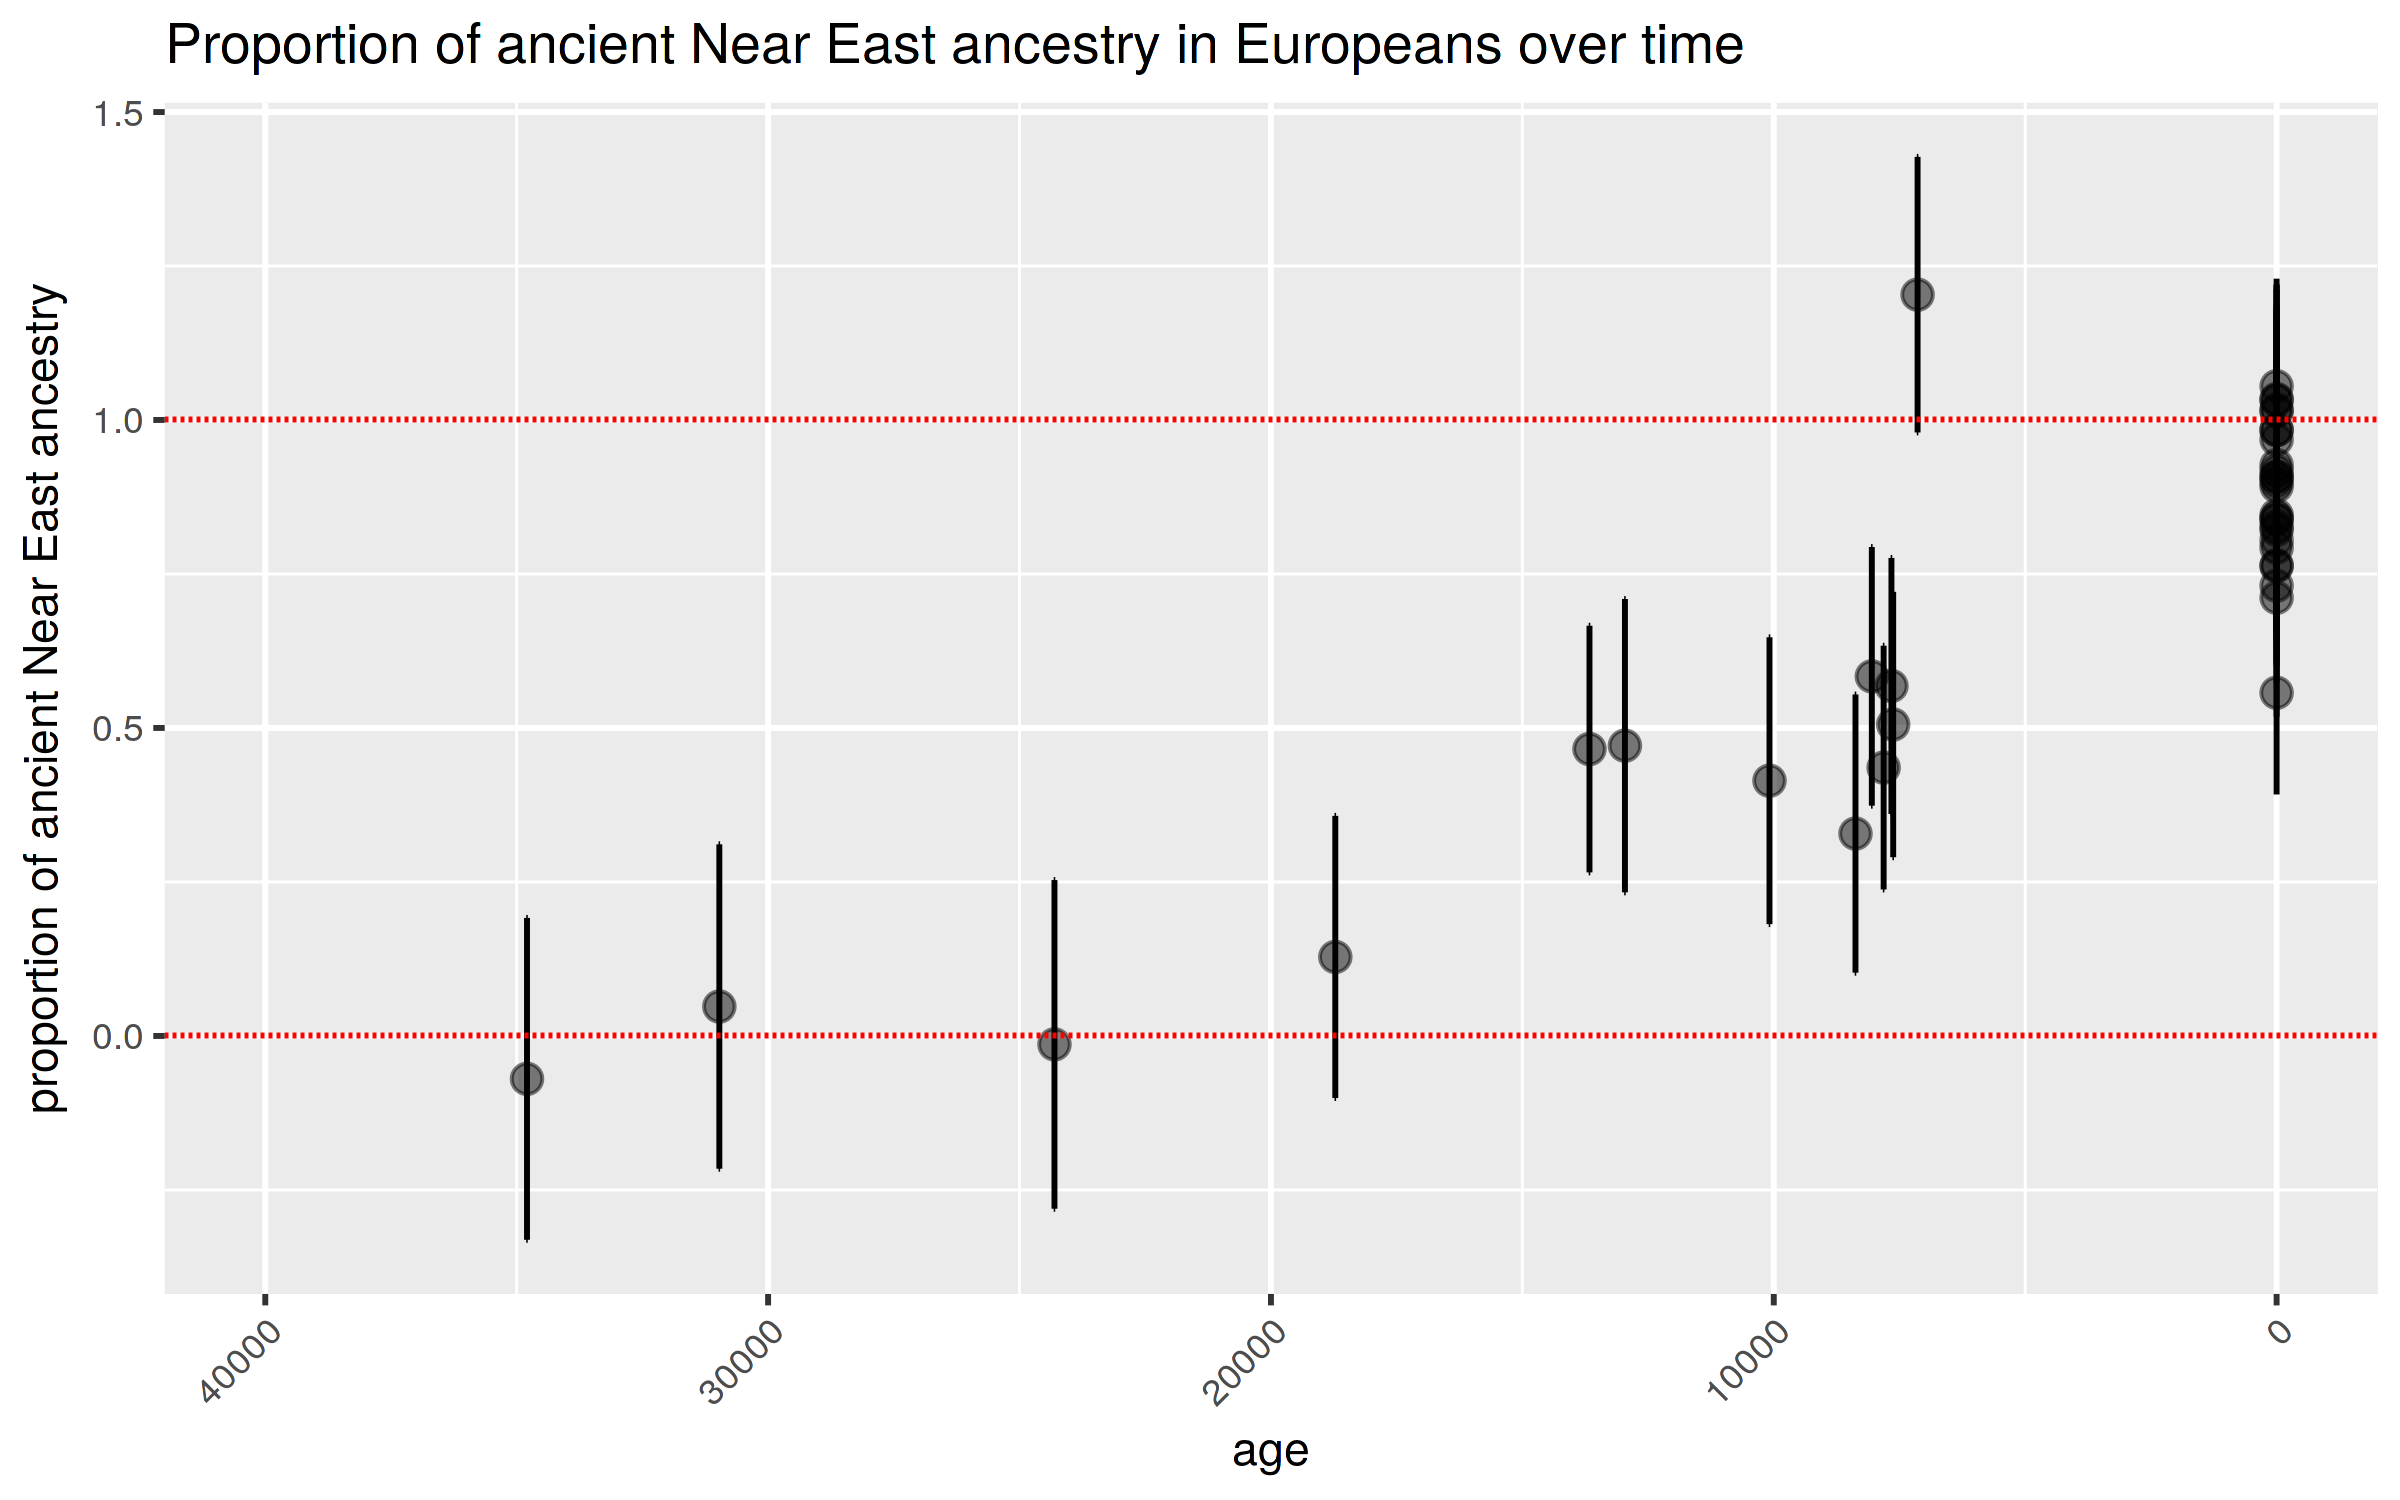

In [8]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=300)

## F4 ratios of Near eastern ancestry in present-day and UP humans over time
near_east_proportion %>% filter(B == "Levant_N", A == "Yemenite_Jew") %>% filter(snp_count > 150000) %>% 
filter(!X %in% non_udg_samples) %>% 
ggplot(aes(age, alpha)) +
    geom_point(size=3, alpha=1/2) +
    geom_errorbar(aes(ymin=alpha - 3 * stderr, ymax=alpha + 3 * stderr)) +
    geom_hline(yintercept=c(0, 1), linetype=2, color="red") +
    xlim(40000, 0) + labs(y="proportion of ancient Near East ancestry") +
    ggtitle("Proportion of ancient Near East ancestry in Europeans over time") +
    theme(legend.position="none", axis.text.x=element_text(angle=45, hjust=1))

In agreement with the D statistics analysis above, this indicates that the proportion of Near Eastern ancestry in Europe:

* Is higher in later ancient samples compared to the earliest ones.
* __Is even higher for the present-day samples__, which suggests that the gene-flow from the Near East continued even during the last ~8 ky.

__Question__: Is there a better way to estimate the proportion of Near East ancestry?

Specifically, present-day humans show a slightly higher proportion of Near East ancestry than 1.0, which could be a sign of an imperfect phylogeny than the one shown in a diagram above. For example, if the population of Vestonice16 are not direct ancestors of present-day Europeans, this would lead to the underestimation of $1 - \alpha$ and, therefore, to the overestimation of $\alpha$ and to it's value above 1.0?

In [490]:
save.image("../data/RData/admixtools_pop_relationships.ipynb")